# Implementing and Training ConvCNPs for Hydrology 

The ConvCNP ([Convolutional Conditional Neural Process](https://openreview.net/forum?id=Skey4eBYPS)) is a recently introduced member of the neural process family that leverages translation equivariance as an inductive bias when performing inference on sets. This repository contains the  necessary classes and scripts to reproduce the 1d experiments using the CAMELS hydrological dataset.

## Import required pakages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import pandas as pd
import pdb
import torch
import torch.nn as nn
import pickle

from sklearn import preprocessing
from scipy.special import inv_boxcox
from scipy.stats import boxcox
#import stheno.torch as stheno

#import convcnp.data
import convcnp.data_hydro_2
import convcnp.data_hydro_2_extended
import convcnp.data_365
import convcnp.data_loader_pytorch
import NSE
from metrics import *
#import convcnp.task_preprocessing as tp

from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, gamma_logpdf, init_sequential_weights, to_multiple, to_numpy, gamma_stats
from convcnp.plot_utils import *
from convcnp.transformations import *
from convcnp.architectures import SimpleConv, UNet, SeparableConv1d, Conv1d, DepthSepConv1d
from convcnp.convcnp_architectures import DeepSet, ConvDeepSet, FinalLayer, ConvCNP

from numpy import loadtxt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(device)

cuda


## Import data

In [19]:
%%time
filepath = r'../../data/camels_processed/daymet_merged/daymet_data_seed05.csv'
df_raw = pd.read_csv(filepath)

CPU times: user 11 s, sys: 914 ms, total: 11.9 s
Wall time: 11.9 s


In [20]:
basins_file = r'../../../ealstm_regional_modelling/ealstm_regional_modeling/data/basin_list.txt'
selected_basins = loadtxt(basins_file, comments="#", delimiter=",", unpack=False, dtype="int")

In [25]:
%%time

df_raw = df_raw[df_raw['basin'].isin(selected_basins)]
print("Length of dataframe for selected basin: ", len(df_raw))

df_raw.drop(['MOD_RUN'],axis=1,inplace=True)

df_raw.drop_duplicates(inplace=True)
print("Length of dataframe after dropping duplicates: ", len(df_raw))

df_raw = df_raw[df_raw['OBS_RUN']>=0]
print("Length of dataframe after filtering out error values: ", len(df_raw))

df_raw['year'] = df_raw['YR']

Length of dataframe for selected basin:  6518953


KeyError: "['MOD_RUN'] not found in axis"

In [107]:
df = df_raw.copy()

In [108]:
dist='gamma'

transformation = 'log'
trans_fields = ['OBS_RUN',
                'prcp(mm/day)']

if transformation == 'log':
    for trans_field in trans_fields:
        df[trans_field] = log_transform(df_raw[trans_field], 1)
        print(f"log of {trans_field}")

transformation = 'NOboxcox'
trans_fields = ['prcp(mm/day)']
        
if transformation == 'boxcox':
    for trans_field in trans_fields:
        df[trans_field], lambda_val = boxcox_transform(df_raw[trans_field], 1e-6)
        
        for ch in ['(',')','/']:
            trans_field = trans_field.replace(ch,"_")
        
        exec("lambda_" + trans_field + " = " + str(lambda_val))
        print("lambda_" + trans_field + " = ", lambda_val)


log of OBS_RUN
log of prcp(mm/day)


In [109]:
fields = ['OBS_RUN',
          'prcp(mm/day)', 
          'dayl(s)',
          'srad(W/m2)','swe(mm)', 'tmax(C)','tmin(C)', 'vp(Pa)',
          'year'
         ]

for field in fields:
    if field == 'OBS_RUN':
        #df[field], q_min, q_max = normalise(df[field],stats=True)
        df[field], q_mu, q_sigma = standardise(df[field], stats=True)
    else:
        #df[field] = normalise(df[field])
        df[field] = standardise(df[field], stats=False)

In [110]:
if dist=='gamma':
    Q_shift = df['OBS_RUN'].min()
    df['OBS_RUN'] = df['OBS_RUN'] - Q_shift + 1
    print('Shifted')
else:
    print('No shift')

Shifted


## K fold split

In [111]:
%%capture
"""import random
from sklearn.model_selection import KFold
k5fold_dict = {}
#shuffled_basins = random.shuffle(selected_basins)
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(selected_basins)
i=0
for train_index, test_index in kf.split(selected_basins):
    i+=1
    k5fold_dict[f'train_basins_{str(i).zfill(2)}'] = selected_basins[train_index]
    k5fold_dict[f'test_basins_{str(i).zfill(2)}'] = selected_basins[test_index]
    #print("TRAIN:",train_basins,"TEST:",test_basins)
    
for k in k5fold_dict.keys():
    print(k, len(k5fold_dict[k]))"""

### Save dict

In [112]:
"""a_file = open("train_test_splits/k5fold_split.pkl", "wb")
pickle.dump(k5fold_dict, a_file)
a_file.close()"""

'a_file = open("train_test_splits/k5fold_split.pkl", "wb")\npickle.dump(k5fold_dict, a_file)\na_file.close()'

### Load dict

In [113]:
a_file = open("train_test_splits/k5fold_split.pkl", "rb")
k5fold_dict = pickle.load(a_file)

## Train test sets

In [114]:
tr = k5fold_dict['train_basins_01']
te = k5fold_dict['test_basins_01']

print(f'Train test split random: {len(tr)} train and {len(te)} test locations')

Train test split random: 424 train and 107 test locations


In [115]:
%%capture
"""random_train_test_split = True

if random_train_test_split == True:
    fraction_test_locations = 0.1

    #hru02 = ['hru_01']
    hru02 = df['hru02'].unique().tolist()

    #hru04 = 'hru_0101'
    #hru08 = 'hru_01013500'

    hru08 = df['hru08'][df['hru02'].isin(hru02)].unique()
    #hru08 = df['hru08'] == 'hru_01013500'

    rand_locations = np.arange(len(hru08))
    np.random.shuffle(rand_locations)
    num_test_locations = int(len(hru08)*fraction_test_locations)
    rand_locations_test = rand_locations[0:num_test_locations]
    rand_locations_train = rand_locations[num_test_locations:]
    hru08_test = hru08[rand_locations_test]
    hru08_train = hru08[rand_locations_train]

    print(f'Train test split random: {len(rand_locations_train)} train and {len(rand_locations_test)} test locations')
    
else:
    path = 'train_test_splits/hru01_train_001.pkl'
    a_file = open(path, "rb")
    hru08_train = pickle.load(a_file)
    a_file.close()
    
    path = 'train_test_splits/hru01_test_001.pkl'
    a_file = open(path, "rb")
    hru08_test = pickle.load(a_file)
    a_file.close()
    
    print('Train test split not random')"""

In [116]:
df['OBS_RUN_mean'] = df.groupby('hru08')['OBS_RUN'].transform(lambda x: x.mean())
#df['OBS_RUN_log_n_mean'] = df.groupby('hru08')['OBS_RUN_log_n'].transform(lambda x: x.mean())

s_date_tr = '1980-10-01'
e_date_tr = '1995-09-30'

s_date_te = '1995-10-01'
e_date_te = '2010-09-30'

context_channels = ['OBS_RUN',
                    'dayl(s)',
                    #'doy_cos','doy_sin',
                    'prcp(mm/day)', 
                    'srad(W/m2)',  
                    'tmax(C)',
                    'tmin(C)', 
                    'vp(Pa)',
                    #'year'
                   ]

target_channels = context_channels
target_val_channel = ['OBS_RUN_mean']

context_mask = [0,1,1,1,1,1,1]
target_mask = [0,1,1,1,1,1,1]

attributes = [#'gauge_id', 
               'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
               'aridity', 'high_prec_freq', 'high_prec_dur', 
                #'high_prec_timing',
               'low_prec_freq', 'low_prec_dur', 
                #'low_prec_timing', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
               'carbonate_rocks_frac', #'geol_porostiy', 
                'geol_permeability', 
                #'q_mean','runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
               #'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
               #'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
               'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity','soil_conductivity', 
                'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 
                #'water_frac', 'organic_frac', 'other_frac', 
                #'gauge_lat','gauge_lon', 
                'elev_mean', 'slope_mean', 
                #'area_gages2',
                'area_geospa_fabric', 
                'frac_forest', 'lai_max', 'lai_diff', 'gvf_max','gvf_diff', 
                #'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50','root_depth_99', 'hru08'
                ]

df_train = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['basin'].isin(tr))].copy()
df_test_both = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['basin'].isin(te))].copy()
df_test_catchment = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['basin'].isin(te))].copy()
df_test_temporal = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['basin'].isin(tr))].copy()

list_to_drop = ['MNTH','DY','hru02','hru04','RAIM','TAIR','PET','ET','SWE','swe(mm)','PRCP','seed','id_lag','HR']

df_train.drop(list_to_drop,axis=1,inplace=True)
df_test_both.drop(list_to_drop,axis=1,inplace=True)
df_test_catchment.drop(list_to_drop,axis=1,inplace=True)
df_test_temporal.drop(list_to_drop,axis=1,inplace=True)

df_train.reset_index(drop=True,inplace=True)
df_test_temporal.reset_index(drop=True,inplace=True)
df_test_catchment.reset_index(drop=True,inplace=True)
df_test_both.reset_index(drop=True,inplace=True)

In [117]:
%%capture
"""import pickle
step = 5
data = hru08_test
name = "hru01_test"
path = ("train_test_splits/%s_%s.pkl" % (name, str(step).zfill(3)))
print(path)
a_file = open(path, "wb")
pickle.dump(data, a_file)
a_file.close()"""

In [118]:
observed_at_target_flag = True
feature_embedding_flag = True
feature_embedding_key_flag = True
extrapolate_flag = False

timeslice = 365

min_train_points = 50
max_train_points = 165
min_test_points = 150
max_test_points = 200

## Data Generation

In [119]:
path = '../../data/camels_processed/attibutes.csv'
df_att = pd.read_csv(path)
numeric_attributes = df_att.select_dtypes('float64').columns.tolist()
#from sklearn import preprocessing
#df_att_n = pd.DataFrame()
for att in numeric_attributes:
    df_att[att] = standardise(df_att[att])

#df_att_n['hru08'] = df_att['hru08']
#df_att.describe()

## Model

In [120]:
import importlib
#importlib.reload(convcnp.task_preprocessing)
#importlib.reload(convcnp.data_hydro_2_extended)

In [121]:
importlib.reload(convcnp.convcnp_architectures)
importlib.reload(convcnp.task_preprocessing)
importlib.reload(convcnp.data_hydro_2_extended)
#importlib.reload(convcnp.architectures)
from convcnp.convcnp_architectures import *
from convcnp.architectures import *

In [155]:
%%capture

# Define parameters
dynamic_embedding_dims = 10
static_embedding_dims = 5

concat_static_features = False
static_feature_embedding = True

static_embedding_location = "after_encoder"
static_feature_missing_data = True
static_masking_rate=0.25

encoder_out_channels = 8

rho_in_channels = encoder_out_channels if static_embedding_location != "after_encoder" else 8 + static_embedding_dims
static_embedding_in_channels = 2 if static_feature_missing_data else len(attributes)

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(context_channels),
                rho=SimpleConv(),
                #rho=UNet(),
                #rho=DepthSepConv1d(in_channels=rho_in_channels, conv_channels=64, num_layers=7, kernel_size=15),
                points_per_unit=64*8,
                dynamic_embedding_dims=dynamic_embedding_dims,
                static_embedding_dims=static_embedding_dims,
                static_feature_embedding=static_feature_embedding,
                static_embedding_in_channels=static_embedding_in_channels,
                static_feature_missing_data=static_feature_missing_data,
                static_embedding_location=static_embedding_location,
                distribution=dist)

# Assign model to device
model.to(device)

In [156]:
model.num_params

7298

## Training Data Generation

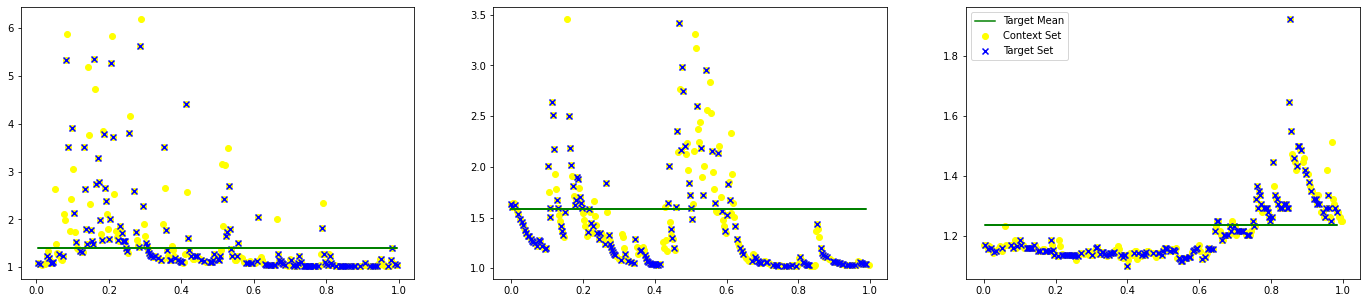

In [157]:
gen = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_train,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = 256,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0.3,
                                            concat_static_features = concat_static_features,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )
        

task = gen.generate_task()
fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_task(task, i, legend=i==2)
plt.show()

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [158]:
import importlib
importlib.reload(convcnp.transformations)
from convcnp.transformations import *

In [159]:
def rev_transform(x,a=0,b=0):
    #return x
    #return rev_log_transform(x-1,e=1)
    #return rev_normalise(x-1,q_min,q_max)
    #return rev_standardise(x-1,q_mu,q_sigma)
    #return rev_log_transform(x,e=1)
    #return rev_normalise(rev_log_transform(x-1,e=1), q_min, q_max)
    return rev_log_transform(x+Q_shift-1,e=1)
    #return rev_boxcox_transform(x,ld=lambda_OBS_RUN)

def rev_transform_tensor(x,a=0,b=0):
    #return x
    #return torch.exp(x-1)-1
    #return torch.exp(x)-1
    #return rev_normalise(x-1,q_min,q_max)
    #return rev_standardise(x-1,q_mu,q_sigma)
    return torch.exp(x+Q_shift-1)-1
    #return rev_normalise(torch.exp(x-1)-1, q_min, q_max)
    #return rev_boxcox_transform_tensor(x,ld=lambda_OBS_RUN)

In [160]:
def task_to_device(task,device='cuda'):
    for k in task.keys():
        task[k] = task[k].to(device)
    return task

def loaded_task(task, device='cuda'):
    if len(task['x'].shape)==4:
        for k in task.keys():
            if task[k].device==device:
                task[k] = task[k].reshape(task[k].shape[1:])
            else:
                task[k] = task[k].reshape(task[k].shape[1:]).to(device)
    else:
        for k in task.keys():
            if task[k].device==device:
                pass
            else:
                task[k] = task[k].to(device)
    return task

def try_to_delete(var_list):
    for var in var_list:
        if var in globals():
            print(f"{var} deleted")
            del var
        else:
            print(f"{var} does not exist")

In [161]:
import scipy.stats

def train(data, model, opt, dist='gaussian'):
    #Perform a training epoch.
    ravg = RunningAverage()
    ravg_nse = RunningAverage() 
    model.train()
    start_1 = time.time()
    task_obj_list = []
    
    for step, task in enumerate(data):
        
        torch.cuda.empty_cache()
        task = loaded_task(task)
        
        y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                               task['feature'], task['m'], 
                               static_masking_rate=static_masking_rate, 
                               embedding=feature_embedding_flag)  
        
        if dist == 'gaussian':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gamma':
            y_mean, y_std = gamma_stats(y_loc, y_scale)
            obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        
        obj.backward()
        opt.step()
        opt.zero_grad()
              
        obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))
        task_obj_list.append(obj)
        ravg.update(obj.item(), data.batch_size)
        ravg_nse.update(obj_nse.item(), data.batch_size)
        
        if step % 100 == 0:
            print("step %s -- avg training loss is %.3f" % (step, ravg.avg)) 
            
    plt.plot(task_obj_list)
    plt.show
        
    return ravg.avg, ravg_nse.avg

In [162]:
# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)


def plot_model_task(model, task, timeslice, idx, legend, dist='gaussian', feature_embedding_flag=True):
    num_functions = task['x_context'].shape[0]
    x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)
    
    # Make predictions with the model.
    model.eval()
    with torch.no_grad():
        y_loc, y_scale = model(task['x_context'], 
                               task['y_context'], 
                               x_test.repeat(num_functions, 1, 1), 
                               task['y_att'], 
                               task['feature'],
                               task['m'],
                               embedding=feature_embedding_flag)
        
        #y_loc_NSE, y_scale_NSE = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)

    # Plot the task and the model predictions.
    x_context, y_context = to_numpy(task['x_context'][idx]), to_numpy(task['y_context'][idx][:,0])
    x_target, y_target = to_numpy(task['x_target'][idx]), to_numpy(task['y_target'][idx][:,0])
    #y_mean_NSE, y_std_NSE = to_numpy(y_mean_NSE[idx][:,0]), to_numpy(y_std_NSE[idx][:,0])
    y_target_val = to_numpy(task['y_target_val'][idx][:,0])
    
    if dist == 'gaussian':
        y_mean, y_std = y_loc, y_scale
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        p05, p95 = y_mean + 2 * y_std, y_mean - 2 * y_std
        #y_mean_NSE, y_std_NSE = y_loc_NSE, y_scale_NSE
    elif dist == 'gamma':
        y_mean, y_std = gamma_stats(y_loc, y_scale)
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        y_loc, y_scale = to_numpy(y_loc[idx][:,0]), to_numpy(y_scale[idx][:,0])        
        p05 = scipy.stats.gamma.ppf(0.05, y_loc, 0, 1/y_scale)
        p95 = scipy.stats.gamma.ppf(0.95, y_loc, 0, 1/y_scale)
        #y_mean_NSE, y_std_NSE = gamma_stats(y_loc_NSE, y_scale_NSE)

    #nse = NSE.nse(rev_transform(y_target), rev_transform(y_target_val), rev_transform(y_mean_NSE))
    #log_nse = NSE.nse(y_mean_NSE, y_target_val, y_target)
    
    x_context = x_context*timeslice
    x_target = x_target*timeslice
    x_test = to_numpy(x_test[0,:,0])*timeslice
    
    plt.scatter(x_context, rev_transform(y_context), label='Context Set', color='black')
    plt.scatter(x_target, rev_transform(y_target), label='Target Set', color='red')
    #plt.scatter(x_target, rev_transform(y_mean_NSE), label='Target Predictions', color='orange')
    plt.plot(x_target, rev_transform(y_target_val), label='Target Mean', color='green')

    # Plot model predictions.
    plt.plot(x_test, rev_transform(y_mean), label='Model Output', color='blue')
    plt.fill_between(x_test,
                     rev_transform(p95),
                     rev_transform(p05),
                     color='tab:blue', alpha=0.2)
        
    #plt.title("NSE(1): %.3f " % nse)
    #plt.xlabel("Q")
    #plt.ylabel("y-label")
        
    if legend:
        plt.legend()

In [163]:
df_test = df_test_both

# Instantiate data generator for testing.
NUM_TEST_TASKS = 128
gen_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = False,
                                            concat_static_features=concat_static_features,
                                            timeslice = timeslice,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device = 'cpu'
                                            )

In [164]:
def get_batch_size(x):
    if x.__class__ == 'torch.utils.data.dataloader.DataLoader':
        return x.dataset.gen.batch_size
    else:
        return x.batch_size

In [165]:
def test(gen_test,model,dist='gaussian',fig_flag=False):
    # Compute average task log-likelihood.
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    
    model.eval()
    start = time.time()
    
    with torch.no_grad():
        for step, task in enumerate(gen_test):
            torch.cuda.empty_cache()
            task = loaded_task(task)
            y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                                   task['feature'], task['m'], 
                                   static_masking_rate = static_masking_rate,
                                   embedding=feature_embedding_flag)        
            if dist == 'gaussian':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            elif dist == 'gamma':
                y_mean, y_std = gamma_stats(y_loc, y_scale)
                obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            
            batch_size = get_batch_size(gen_test)
            
            obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))        
            ravg.update(obj.item(), batch_size)
            #print(batch_size)
            ravg_nse.update(obj_nse.item(), batch_size)

    if fig_flag:
        fig = plt.figure(figsize=(24, 15))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plot_model_task(model, task, timeslice, idx=i, legend=i==2, dist=dist)
        plt.show()

        elapsed = time.time() - start        
        print('Test NLL: %.3f -- NSE: %.3f -- time: %.3f' % (ravg.avg, ravg_nse.avg, elapsed))
    
    return ravg.avg


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [166]:
importlib.reload(convcnp.convcnp_architectures)
from convcnp.convcnp_architectures import *

importlib.reload(convcnp.plot_utils)
from convcnp.plot_utils import *

from IPython import display
from convcnp.experiment import *

In [167]:
importlib.reload(convcnp.data_loader_pytorch)
from convcnp.data_loader_pytorch import *
gen.batch_size = 16*2
gen_test.batch_size = 16*2

gen.dropout_rate = 0
gen_test.dropout_rate = 0
static_masking_rate = 0

train_dataloader = DataLoader(dataset=HydroDataset(gen,num_tasks_epoch=1024), batch_size=1, num_workers=8, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(dataset=HydroDataset(gen_test,num_tasks_epoch=256), batch_size=1, num_workers=8, shuffle=False, pin_memory=True)

In [168]:
change_folder = True

if change_folder:
    experiment_name = 'k5fold_01_gamma_log_staticfs_after-encoder_SimpleConv'
    wd = WorkingDirectory(generate_root(experiment_name))

Root: _experiments/2020-07-31_11-59-01_k5fold-01-gamma-log-staticfs-after-encoder-simpleconv


In [169]:
load_model = False
load_dict = False

load_root = '_experiments/2020-07-30_19-55-44_k5fold-01-gaussian-log-rainfallboxcox-staticfs-after-encoder-unet'

if load_model:
    #PATH = f'{load_root}/checkpoint.pth.tar'
    PATH = f'{load_root}/e_61_loss_151.753.pth.tar'
    model.load_state_dict(torch.load(PATH))
    
if load_dict:
    a_file = open(os.path.join(load_root,"loss_dict.pkl"), "rb")
    loss_dict = pickle.load(a_file)
    a_file.close()
    
    epoch_list = loss_dict['epochs']
    train_obj_list = loss_dict['training_loss'] 
    train_nse_list = loss_dict['training_nse'] 
    test_obj_list = loss_dict['test_loss'] 

In [170]:
reset_epochs = True

if reset_epochs:
    train_obj_list, train_nse_list, test_obj_list, epoch_list = [], [], [], []

In [171]:
torch.cuda.empty_cache()
try_to_delete(['task','minitask'])

task deleted
minitask does not exist


In [172]:
load_best = False
if load_best:
    model.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))

In [173]:
torch.autograd.set_detect_anomaly(True)

# Some training hyper-parameters:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 500
PLOT_FREQ = 1

plot_model = False

if len(epoch_list)>0:
    last_epoch = epoch_list[-1]
else:
    last_epoch = 0

# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Run the training loop.
for epoch in range(NUM_EPOCHS):
    # Compute training objective.
    start_time = time.time()
    train_obj, train_nse = train(train_dataloader, model, opt, dist=dist)

    epoch_list.append(epoch+last_epoch)
    train_obj_list.append(train_obj)
    train_nse_list.append(train_nse)
    
    torch.cuda.empty_cache()
    test_obj = test(test_dataloader,model,dist=dist)
    test_obj_list.append(test_obj)
    
    elapsed = time.time() - start_time
    
    print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch+last_epoch, train_obj, test_obj, train_nse, elapsed))

    # Plot model behaviour every now and again.
    if (epoch % PLOT_FREQ == 0) and plot_model:
        task = task_to_device(gen_test.generate_task())
        fig = plt.figure(figsize=(24, 5))
        for i in range(1):
            plt.subplot(1, 1, i + 1)
            plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)
        plt.title('Test set')
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        #plot training loss

    print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch + last_epoch, train_obj, test_obj, train_nse, elapsed))

    plot_training_loss(train_obj_list, test_obj_list)
    plt.show()
    
    save_as_best = True if test_obj == min(test_obj_list) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch + last_epoch, test_obj))
    torch.save(model.state_dict(), PATH)
    
    #SAVEPATH = os.path.join(wd.root,'checkpoint_epoch_%s_score_%.3f.pth.tar' % (epoch, test_obj))
    #torch.save(model.state_dict(),SAVEPATH)
    
    #if test_obj == min(test_obj_list):
    #    torch.save(model.state_dict().os.path.join(wd.root,'model_best.pth.tar'))

step 0 -- avg training loss is 328.283


RuntimeError: Function 'SumBackward1' returned nan values in its 0th output.

In [39]:
save_dict = True

if save_dict:
    model_hyperparams={}
    model_hyperparams['lr'] = LEARNING_RATE
    model_hyperparams['distribution'] = dist
    model_hyperparams['train_batch_size'] = gen.batch_size
    model_hyperparams['batches_per_epoch'] = train_dataloader.dataset.num_tasks_epoch
    model_hyperparams['static_masking_rate'] = static_masking_rate
    model_hyperparams['dynamic masking rate'] = gen.dropout_rate
    model_hyperparams['static_embedding_dims'] = static_embedding_dims
    model_hyperparams['dynamic_embedding_dims'] = dynamic_embedding_dims

    a_file = open(os.path.join(wd.root,"model_hyperparams.pkl"), "wb")
    pickle.dump(model_hyperparams, a_file)
    a_file.close()
    print('Saved successfuly')


Saved successfuly


In [40]:
save_dict = True

if save_dict:
    loss_dict={}
    loss_dict['epochs'] = epoch_list
    loss_dict['training_loss'] = train_obj_list
    loss_dict['training_nse'] = train_nse_list
    loss_dict['test_loss'] = test_obj_list

    a_file = open(os.path.join(wd.root,"loss_dict.pkl"), "wb")
    pickle.dump(loss_dict, a_file)
    a_file.close()
    print('Saved successfuly')
    

Saved successfuly


## Test model

In [ ]:
ROOT_PATH = '_experiments/2020-07-28_20-49-42_k5fold-01-gamma-log-staticfs-bafter-encoder-defaultdscnn'
model.load_state_dict(torch.load(os.path.join(ROOT_PATH, 'model_best.pth.tar')))

In [37]:
torch.cuda.empty_cache()
try_to_delete(['task'])

task deleted


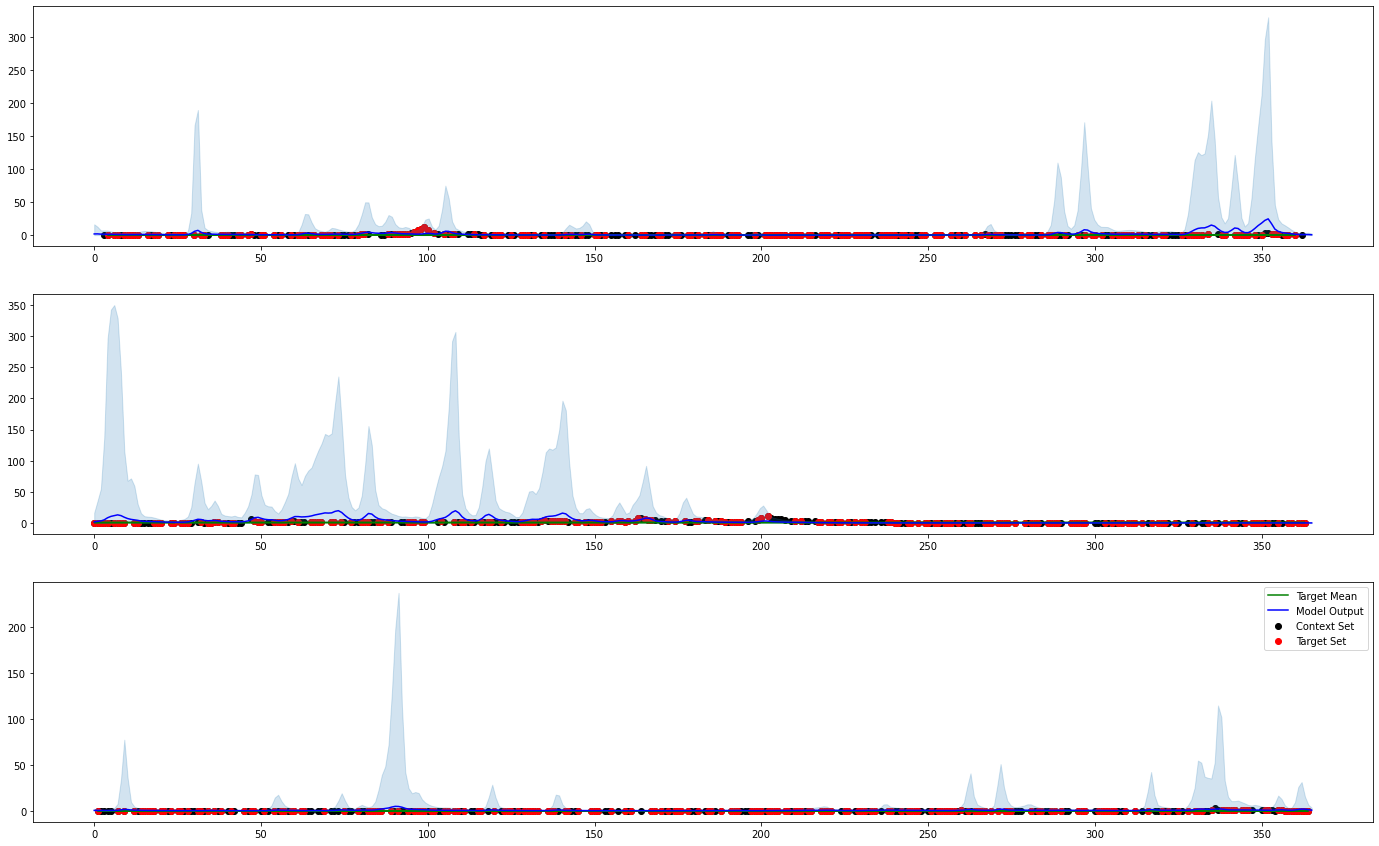

Test NLL: 304.571 -- NSE: -60.025 -- time: 4.930


304.5714650154114

In [38]:
gen_for_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_temporal,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = 32,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0,
                                            concat_static_features = False,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )
        

tester = DataLoader(dataset=HydroDataset(gen_for_test,num_tasks_epoch=64), batch_size=1, shuffle=False, num_workers=24, pin_memory=False)
test(tester,model,dist=dist,fig_flag=True)

## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [ ]:
"""%%capture
#load model
##model = TheModelClass(*args, **kwargs)
PATH = '../../saved_models/model_022.pt'
model.load_state_dict(torch.load(PATH))
model.eval()"""

In [ ]:
"""model_number = 23
save_model_name = f'model_{model_number}_{dist}_static-features_{static_embedding_location}_{s_date_tr}_to_{e_date_tr}'
save_model_name"""

In [ ]:
"""PATH = r'..\..\saved_models\model_022.pt'
torch.save(model.state_dict(),PATH)"""

In [91]:
ROOT_PATH = '_experiments/2020-07-30_19-55-44_k5fold-01-gaussian-log-rainfallboxcox-staticfs-after-encoder-unet'
PATH = f'{ROOT_PATH}/model_best.pth.tar'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Test NSE performance at 365/1-day ahead task

In [92]:
importlib.reload(convcnp.data_hydro_2_extended)
from convcnp.data_hydro_2_extended import *
importlib.reload(NSE)
from metrics import *
import scipy.stats
df_test = df_test_both
importlib.reload(convcnp.data_loader_pytorch)
from convcnp.data_loader_pytorch import *
torch.cuda.empty_cache()

In [93]:
var_list = ['minitask','task']
try_to_delete(var_list)

minitask deleted
task deleted


107


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


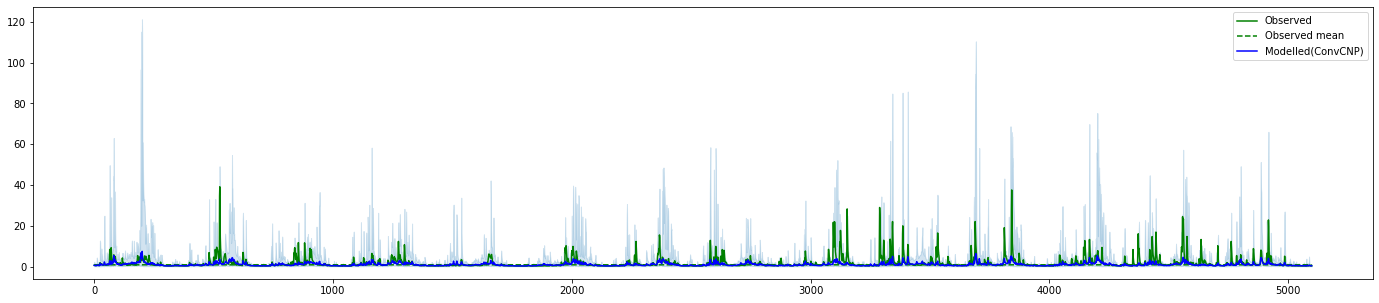

1. Basin hru_01022500 (period: 1997-2010): LL=-0.016 -- NSE=0.628 -- time=19.538


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


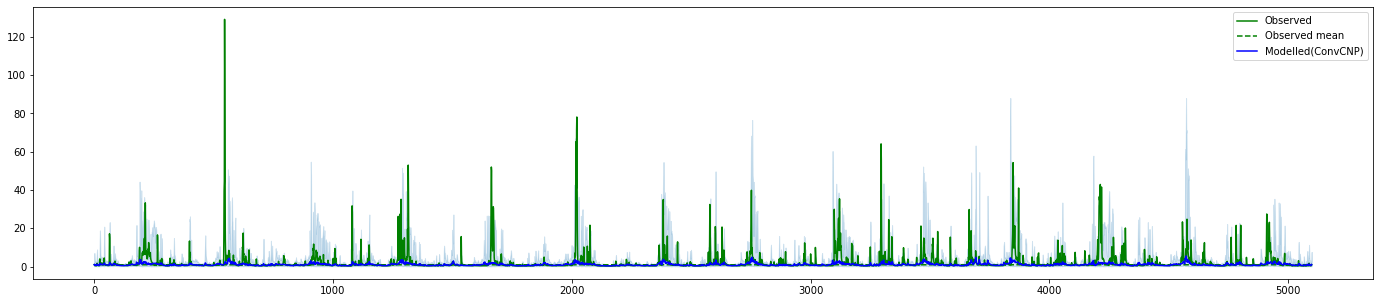

2. Basin hru_01052500 (period: 1997-2010): LL=-0.018 -- NSE=0.482 -- time=19.617


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


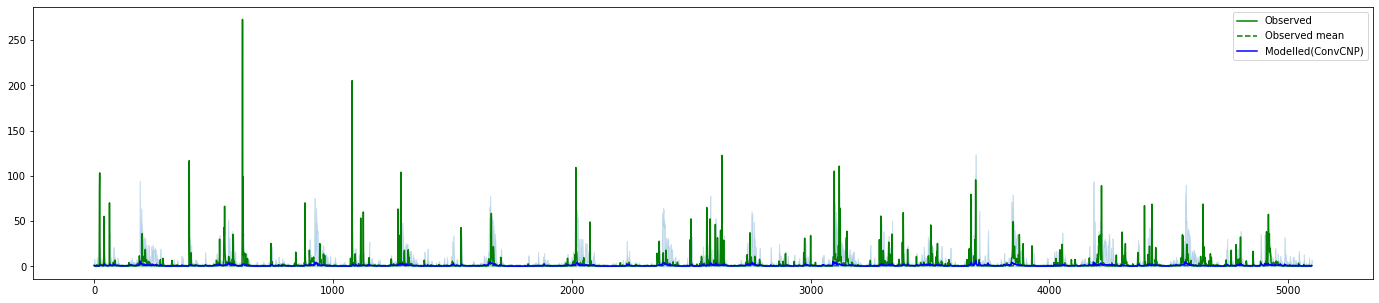

3. Basin hru_01054200 (period: 1997-2010): LL=-0.020 -- NSE=0.469 -- time=19.604


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


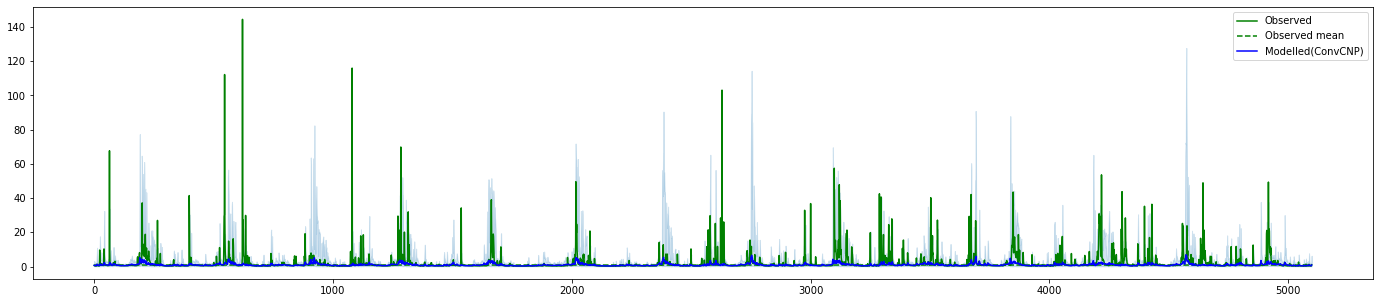

4. Basin hru_01055000 (period: 1997-2010): LL=-0.019 -- NSE=0.506 -- time=19.401


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


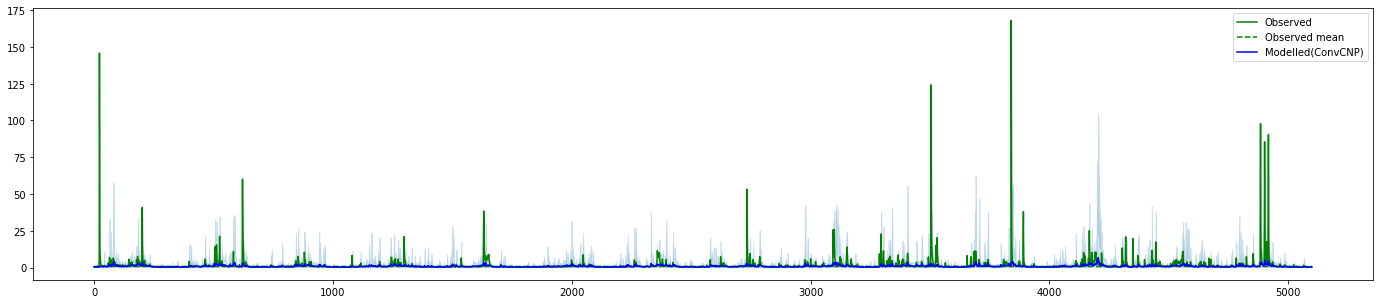

5. Basin hru_01073000 (period: 1997-2010): LL=-0.016 -- NSE=0.632 -- time=19.612


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


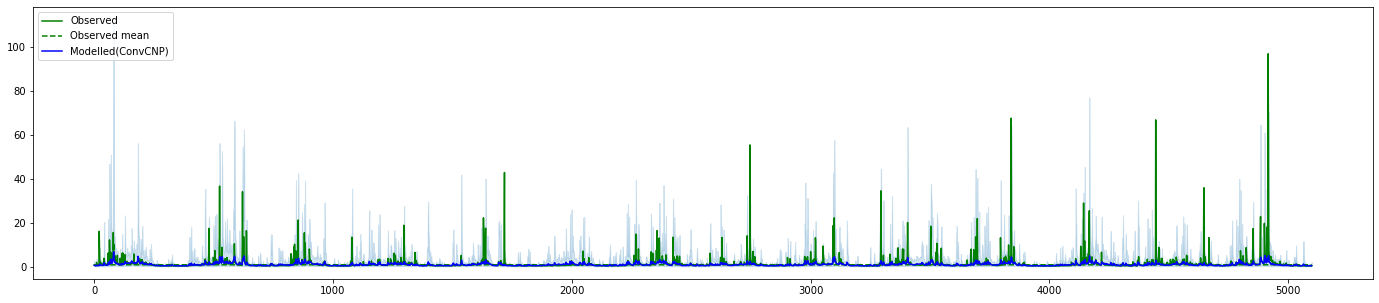

6. Basin hru_01123000 (period: 1997-2010): LL=-0.014 -- NSE=0.658 -- time=19.545


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


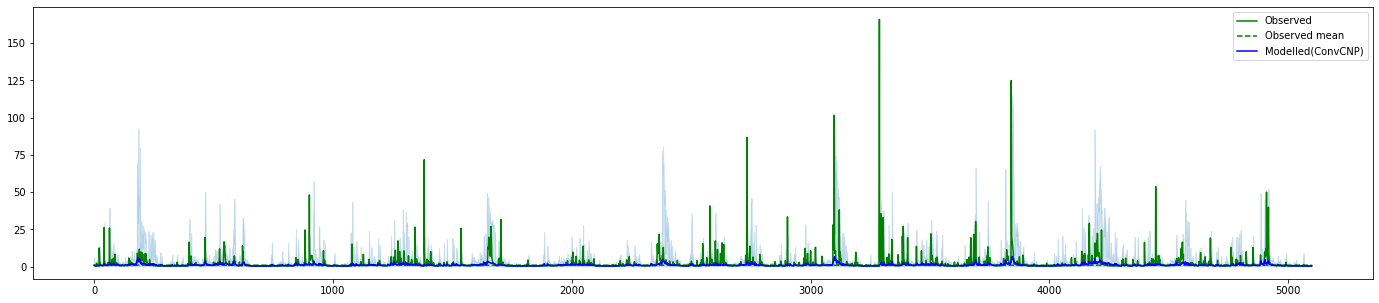

7. Basin hru_01169000 (period: 1997-2010): LL=-0.017 -- NSE=0.546 -- time=19.095


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


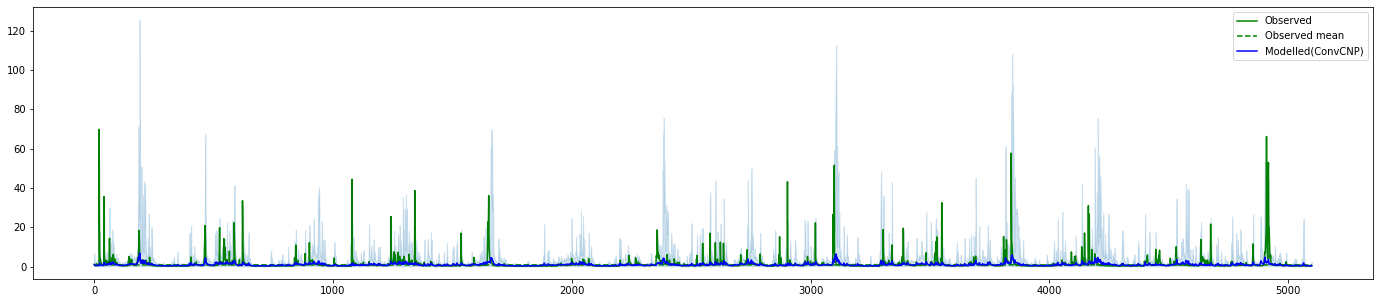

8. Basin hru_01350080 (period: 1997-2010): LL=-0.018 -- NSE=0.510 -- time=19.391


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


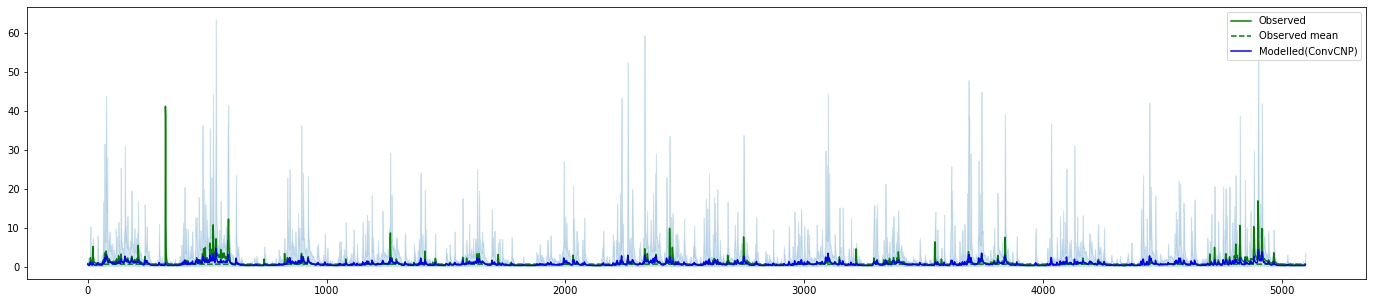

9. Basin hru_01411300 (period: 1997-2010): LL=-0.014 -- NSE=0.540 -- time=19.361


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


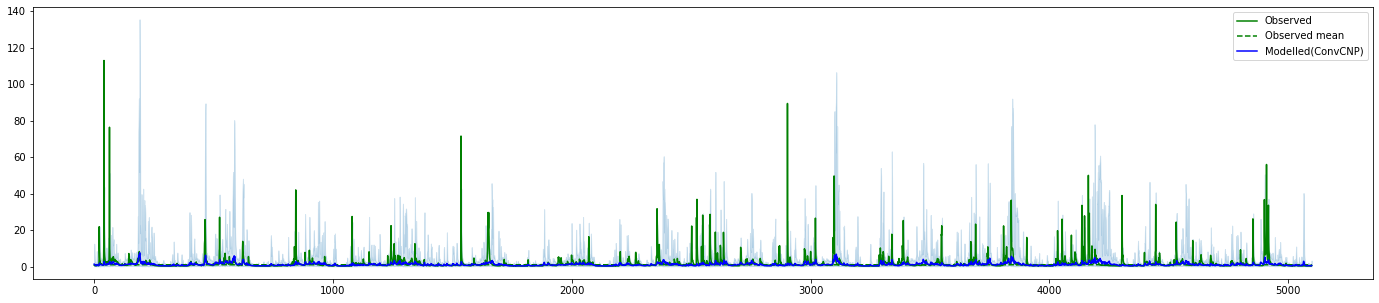

10. Basin hru_01414500 (period: 1997-2010): LL=-0.019 -- NSE=0.493 -- time=19.436


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


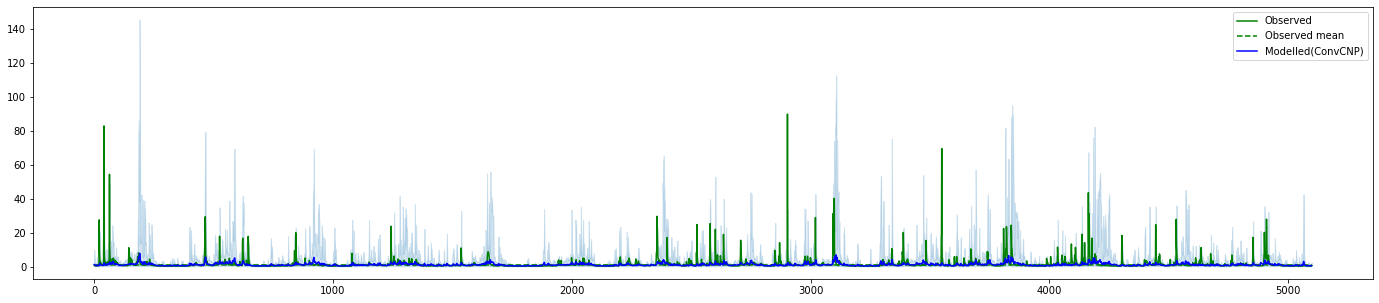

11. Basin hru_01415000 (period: 1997-2010): LL=-0.019 -- NSE=0.494 -- time=19.439


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


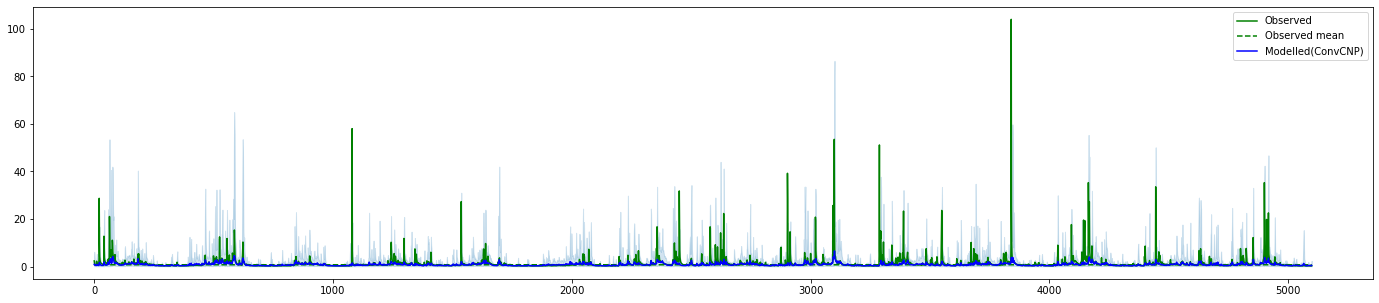

12. Basin hru_01440000 (period: 1997-2010): LL=-0.014 -- NSE=0.635 -- time=19.368


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


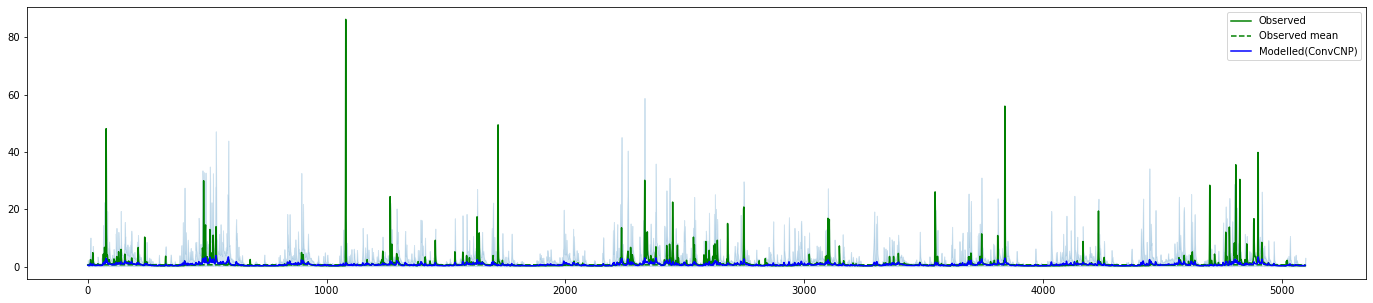

13. Basin hru_01491000 (period: 1997-2010): LL=-0.014 -- NSE=0.575 -- time=19.510


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


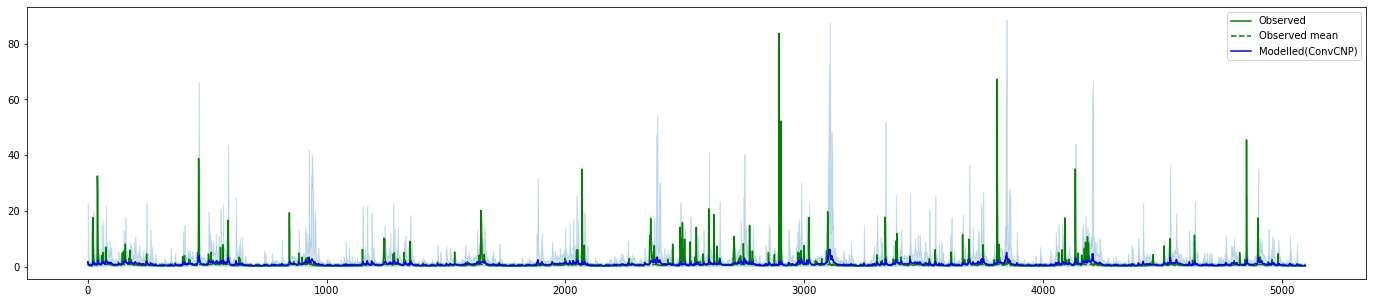

14. Basin hru_01518862 (period: 1997-2010): LL=-0.018 -- NSE=0.425 -- time=20.562


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


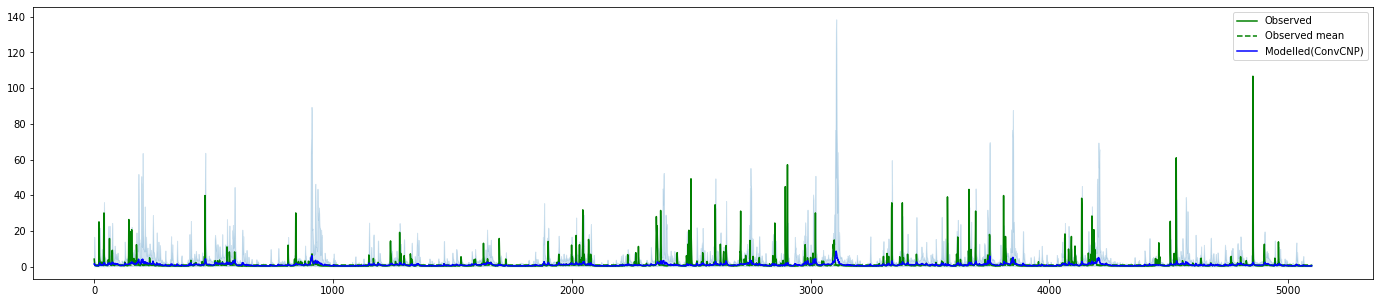

15. Basin hru_01542810 (period: 1997-2010): LL=-0.020 -- NSE=0.455 -- time=20.224


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


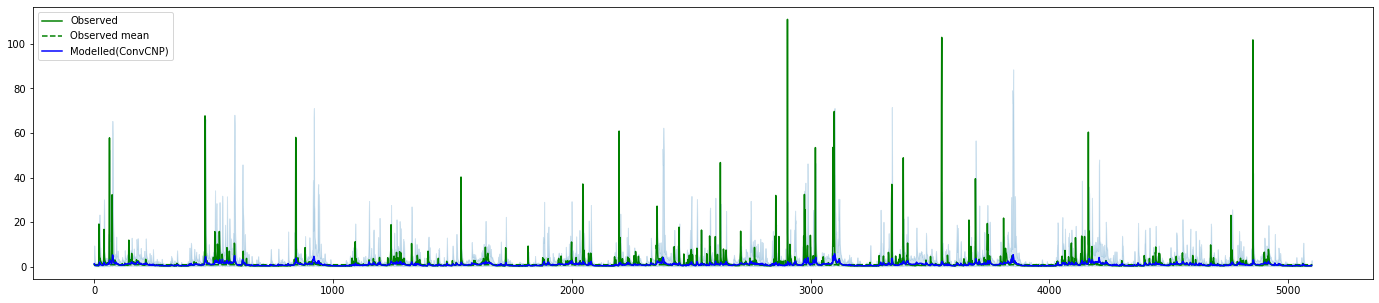

16. Basin hru_01552500 (period: 1997-2010): LL=-0.016 -- NSE=0.586 -- time=19.575


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


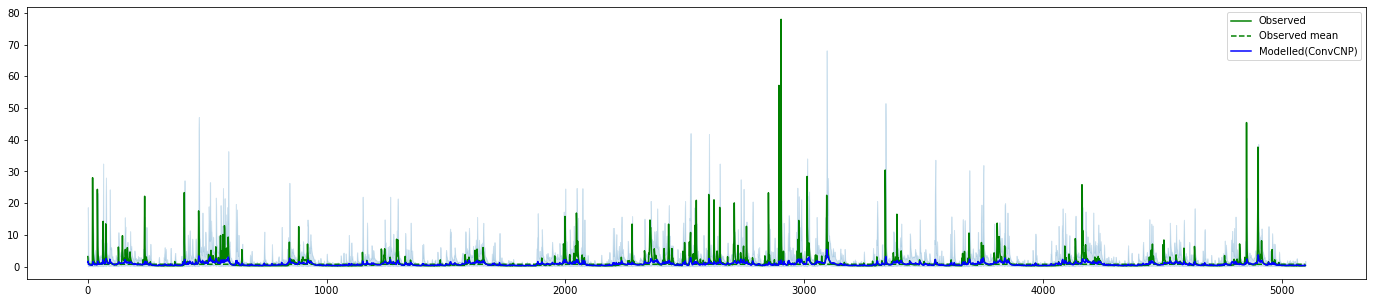

17. Basin hru_01557500 (period: 1997-2010): LL=-0.014 -- NSE=0.630 -- time=19.502


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


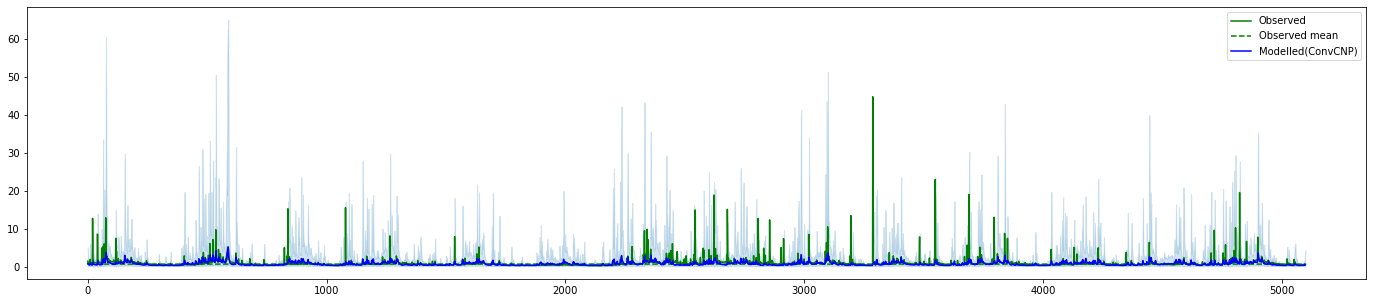

18. Basin hru_01580000 (period: 1997-2010): LL=-0.015 -- NSE=0.329 -- time=19.692


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


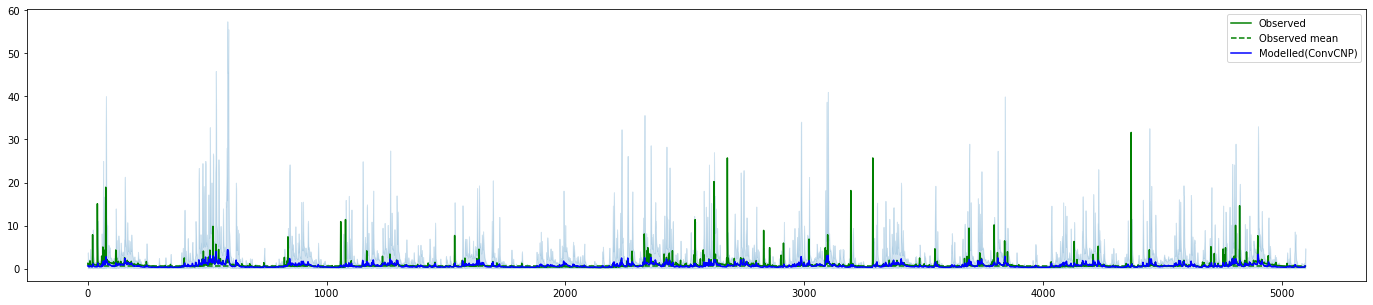

19. Basin hru_01583500 (period: 1997-2010): LL=-0.013 -- NSE=0.367 -- time=19.185


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


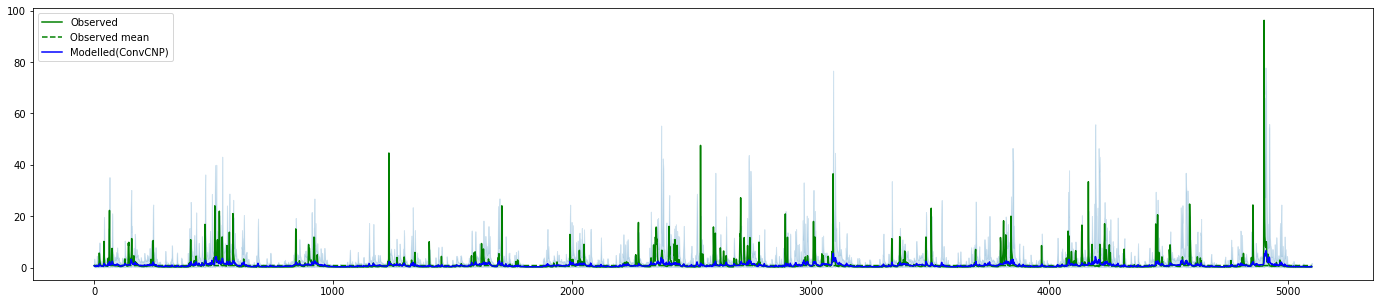

20. Basin hru_01596500 (period: 1997-2010): LL=-0.018 -- NSE=0.563 -- time=19.511


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


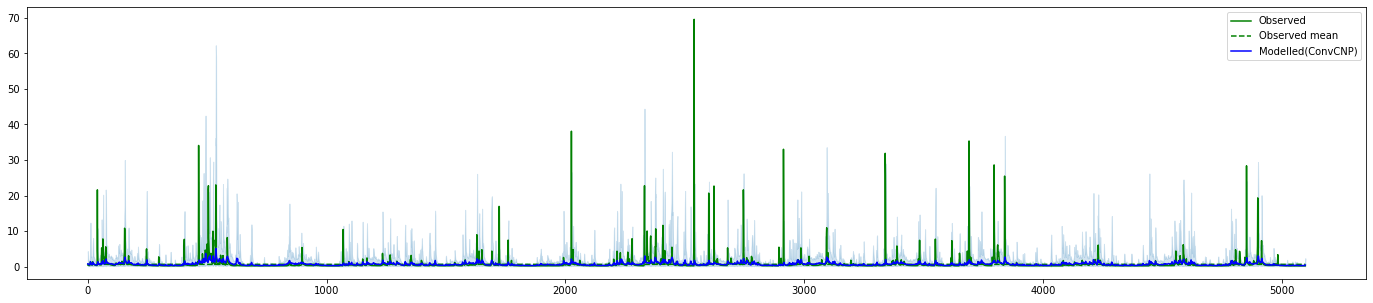

21. Basin hru_01632000 (period: 1997-2010): LL=-0.017 -- NSE=0.413 -- time=19.478


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


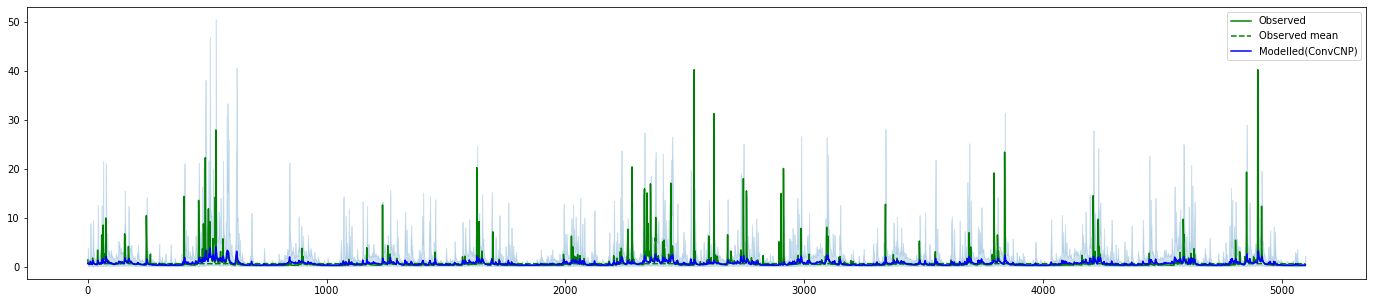

22. Basin hru_01634500 (period: 1997-2010): LL=-0.013 -- NSE=0.531 -- time=19.378


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


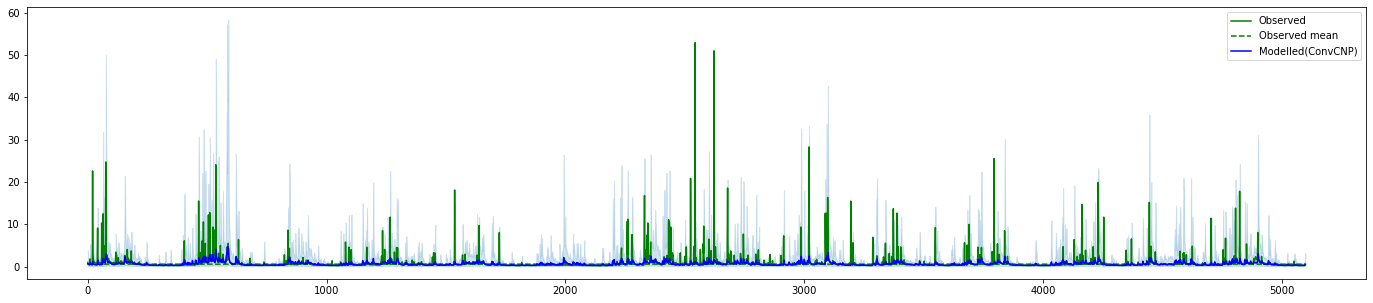

23. Basin hru_01639500 (period: 1997-2010): LL=-0.012 -- NSE=0.556 -- time=19.485


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


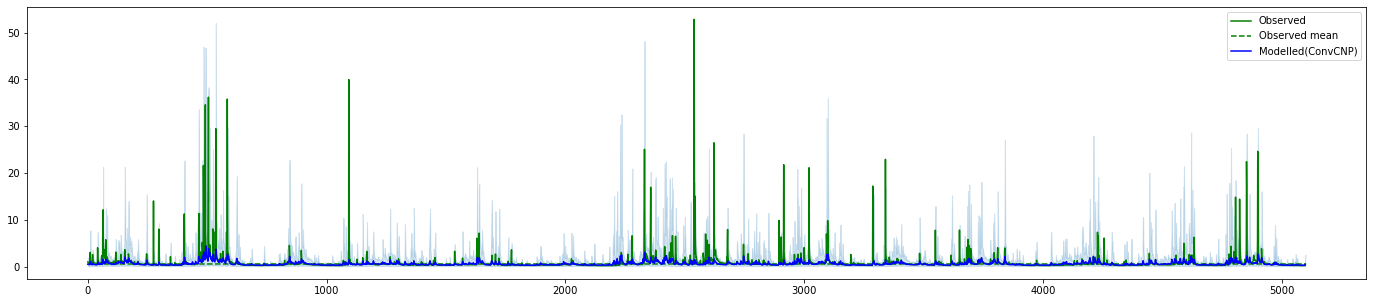

24. Basin hru_01667500 (period: 1997-2010): LL=-0.010 -- NSE=0.647 -- time=19.517


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


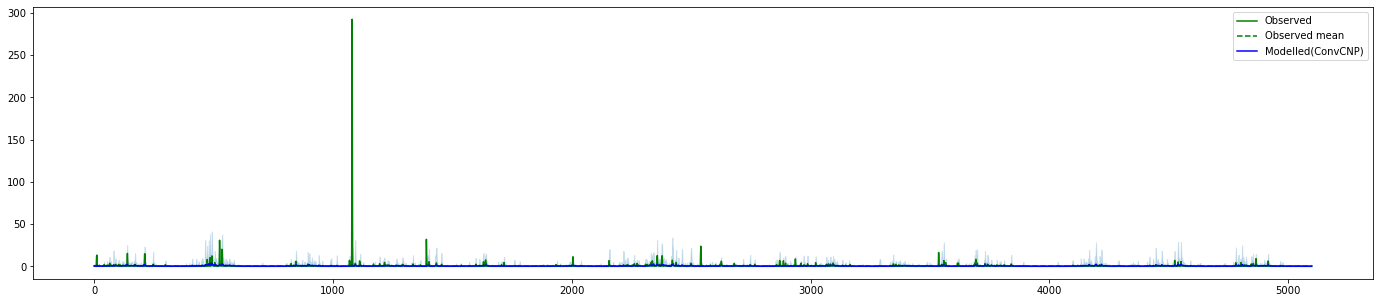

25. Basin hru_02082950 (period: 1997-2010): LL=-0.012 -- NSE=0.563 -- time=19.495


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


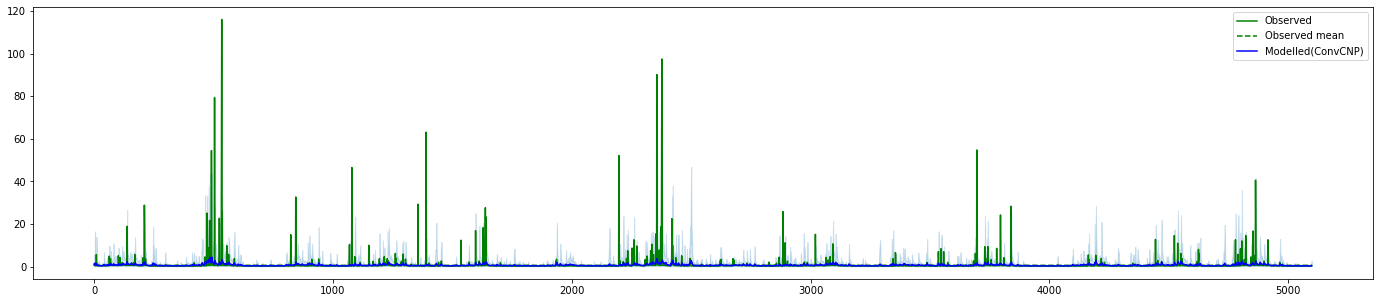

26. Basin hru_02096846 (period: 1997-2010): LL=-0.018 -- NSE=0.168 -- time=20.048


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


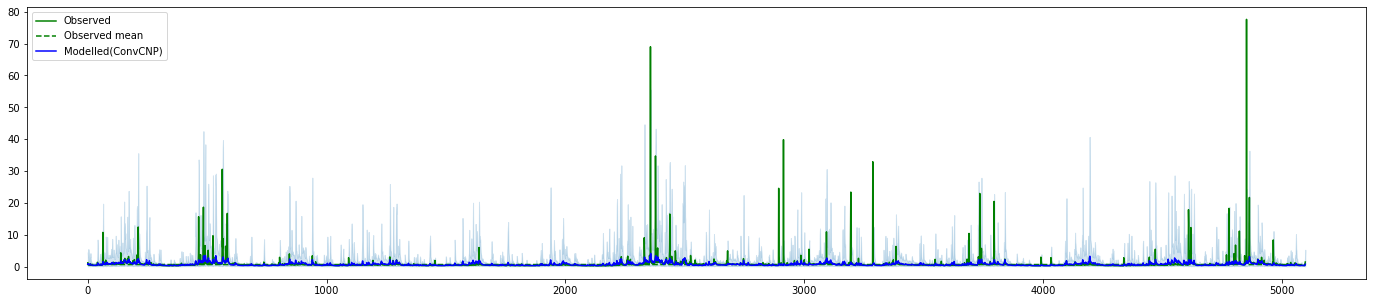

27. Basin hru_02118500 (period: 1997-2010): LL=-0.012 -- NSE=0.476 -- time=19.454


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


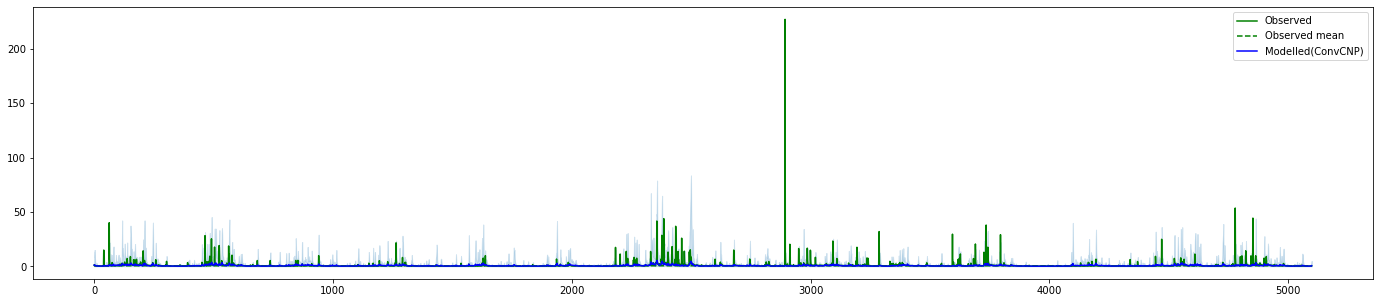

28. Basin hru_02143040 (period: 1997-2010): LL=-0.014 -- NSE=0.539 -- time=19.299


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)


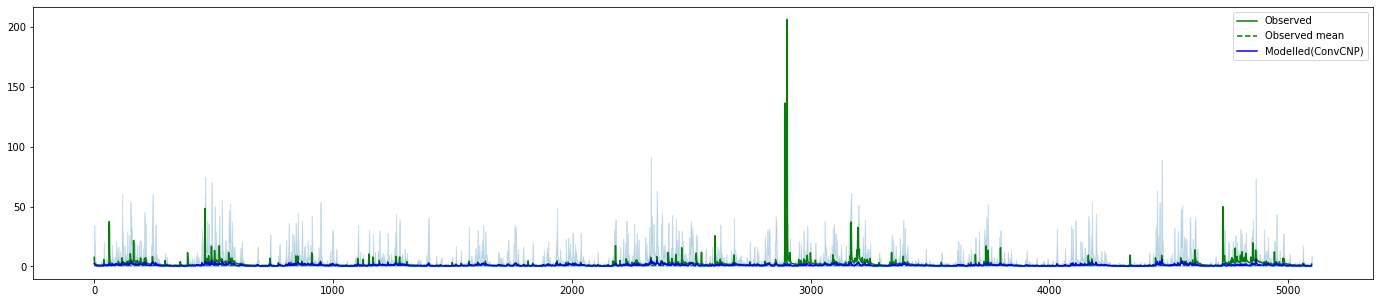

29. Basin hru_02177000 (period: 1997-2010): LL=-0.023 -- NSE=0.203 -- time=19.615


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


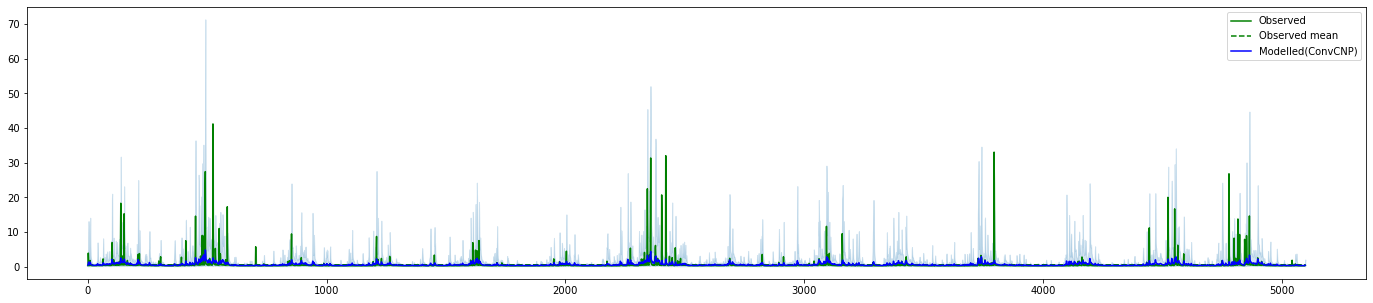

30. Basin hru_02196000 (period: 1997-2010): LL=-0.015 -- NSE=0.077 -- time=20.033


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

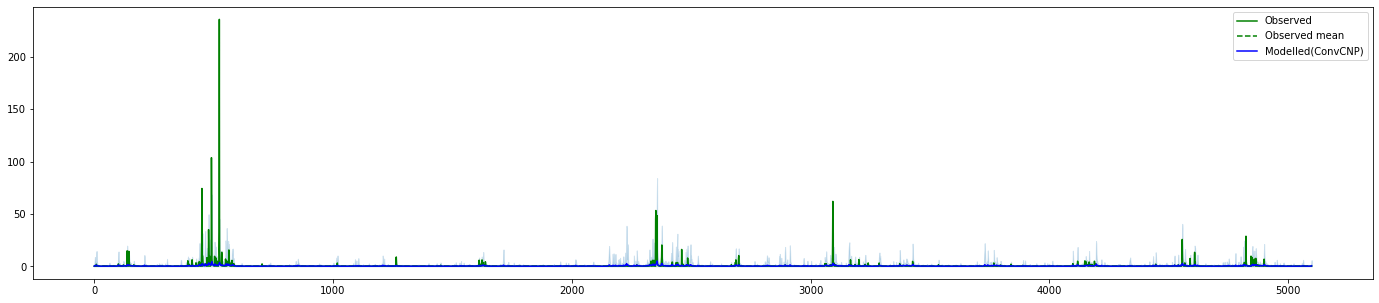

31. Basin hru_02198100 (period: 1997-2010): LL=-0.009 -- NSE=0.587 -- time=19.523


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


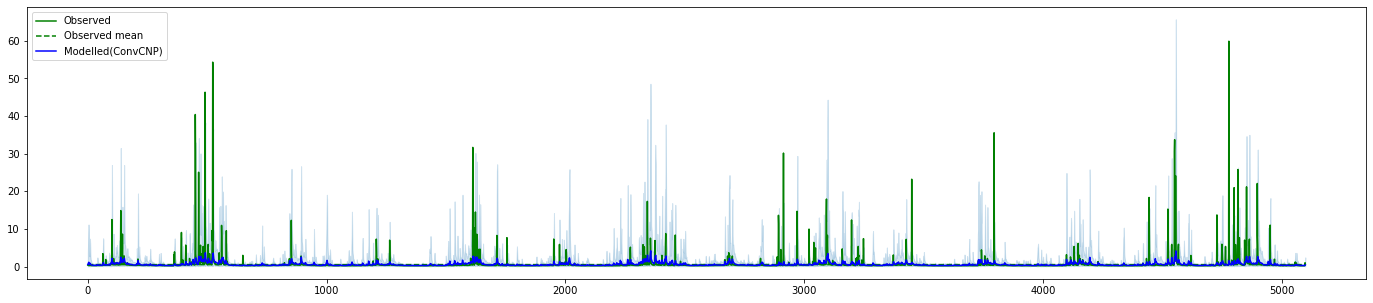

32. Basin hru_02212600 (period: 1997-2010): LL=-0.014 -- NSE=0.406 -- time=19.662


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


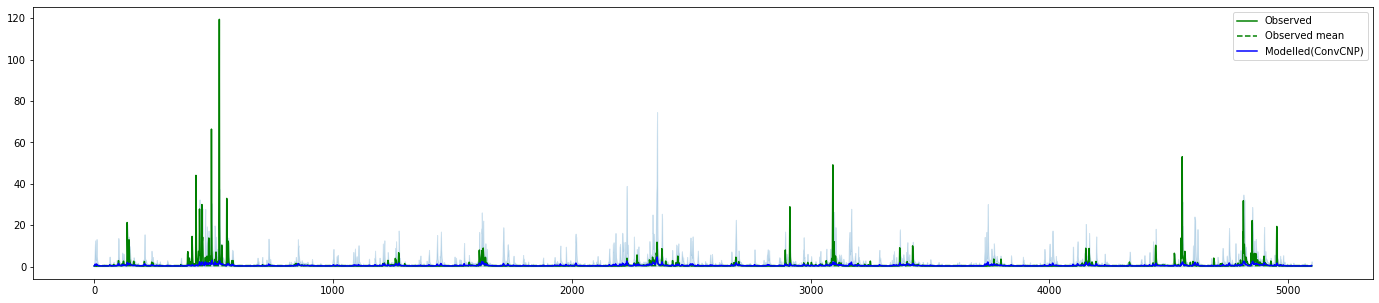

33. Basin hru_02216180 (period: 1997-2010): LL=-0.013 -- NSE=0.531 -- time=19.380


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


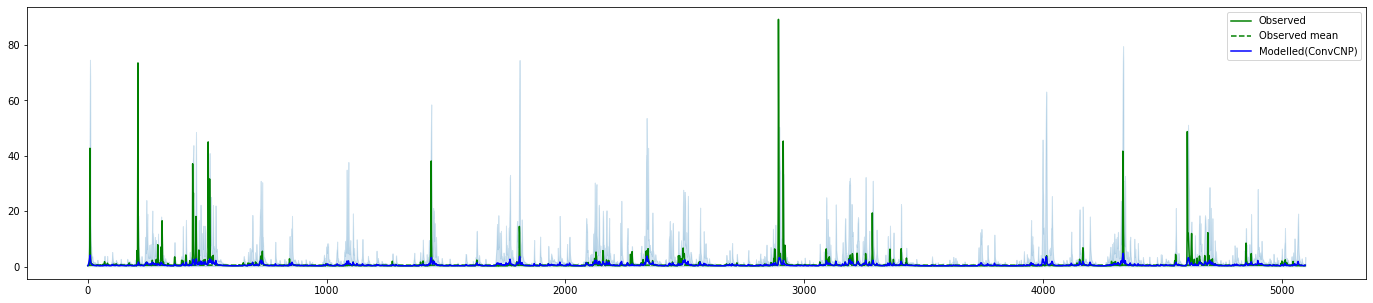

34. Basin hru_02245500 (period: 1997-2010): LL=-0.012 -- NSE=0.570 -- time=19.406


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


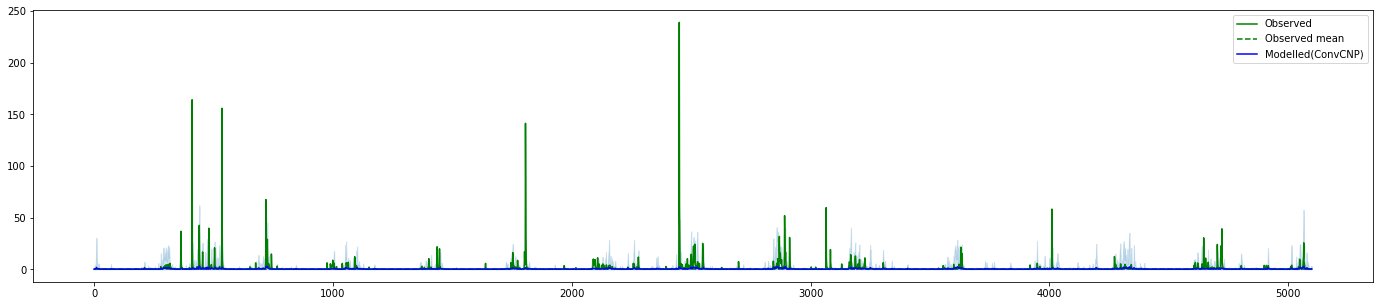

35. Basin hru_02299950 (period: 1997-2010): LL=-0.012 -- NSE=0.513 -- time=19.457


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


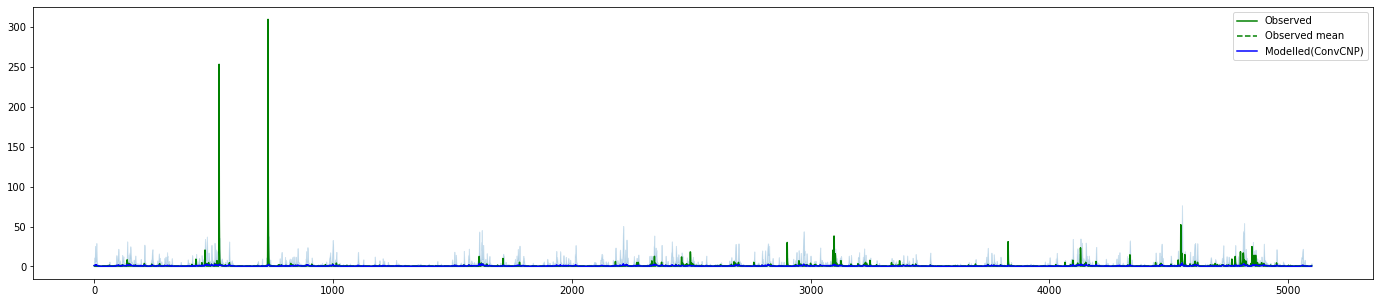

36. Basin hru_02369800 (period: 1997-2010): LL=-0.015 -- NSE=0.484 -- time=19.428


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


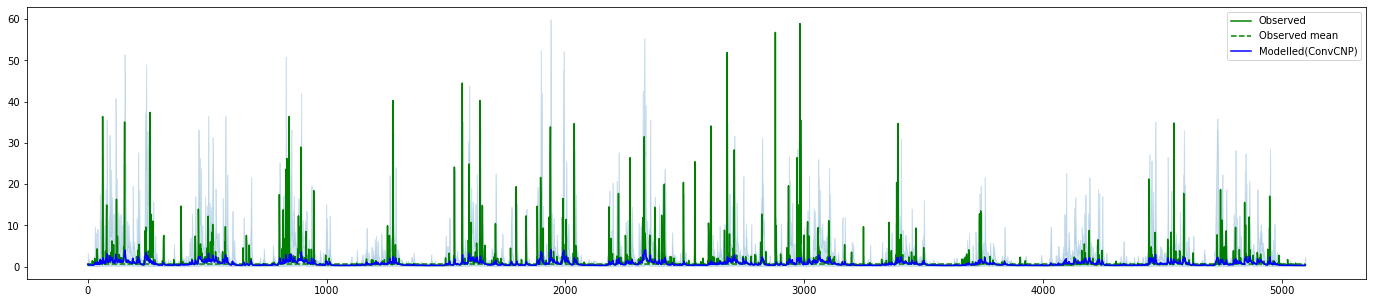

37. Basin hru_02430085 (period: 1997-2010): LL=-0.013 -- NSE=0.572 -- time=19.434


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


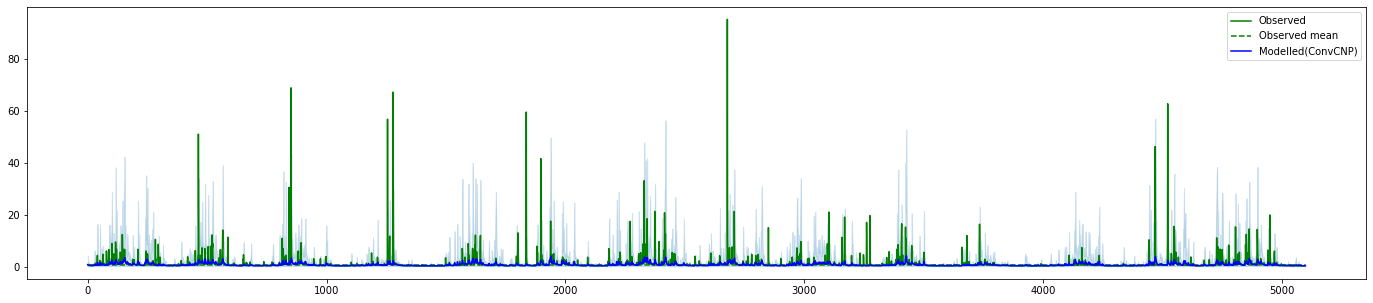

38. Basin hru_02464360 (period: 1997-2010): LL=-0.013 -- NSE=0.572 -- time=19.452


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


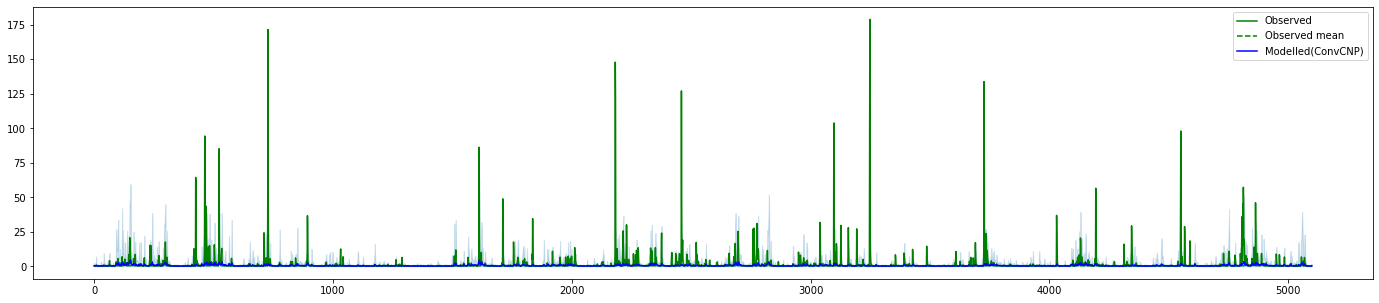

39. Basin hru_02481000 (period: 1997-2010): LL=-0.017 -- NSE=0.530 -- time=19.428


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


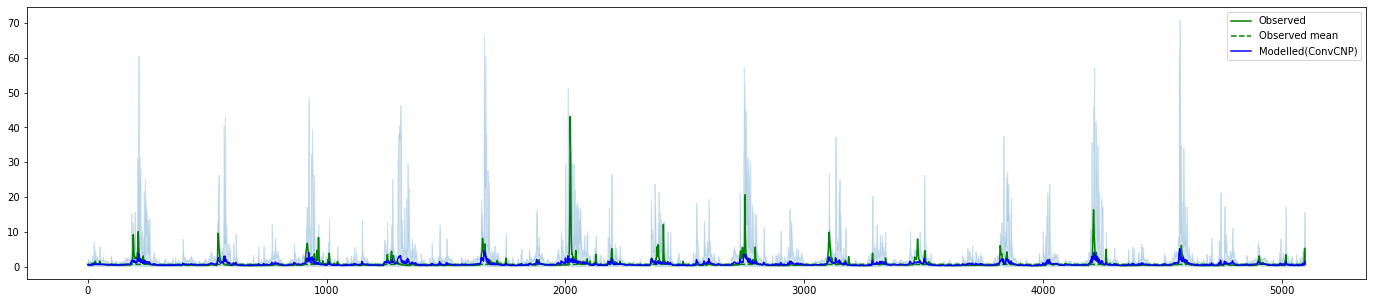

40. Basin hru_04057800 (period: 1997-2010): LL=-0.012 -- NSE=0.484 -- time=20.048


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


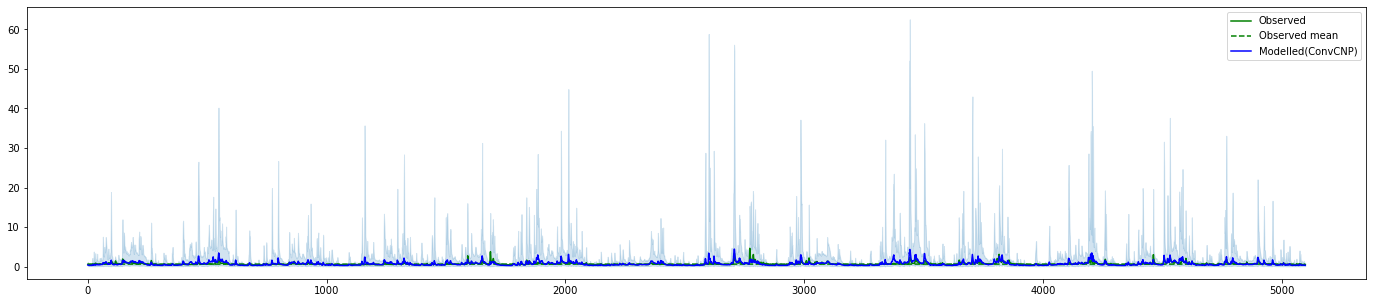

41. Basin hru_04122200 (period: 1997-2010): LL=-0.012 -- NSE=-0.157 -- time=19.862


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


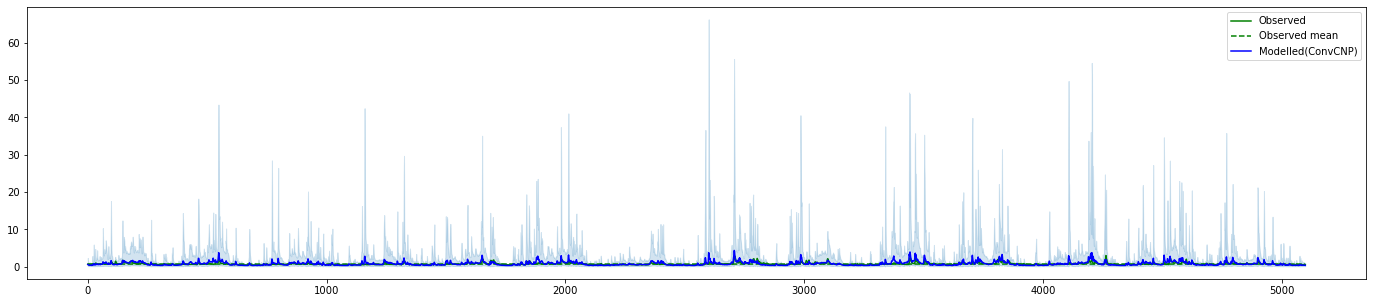

42. Basin hru_04122500 (period: 1997-2010): LL=-0.013 -- NSE=-0.368 -- time=19.509


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


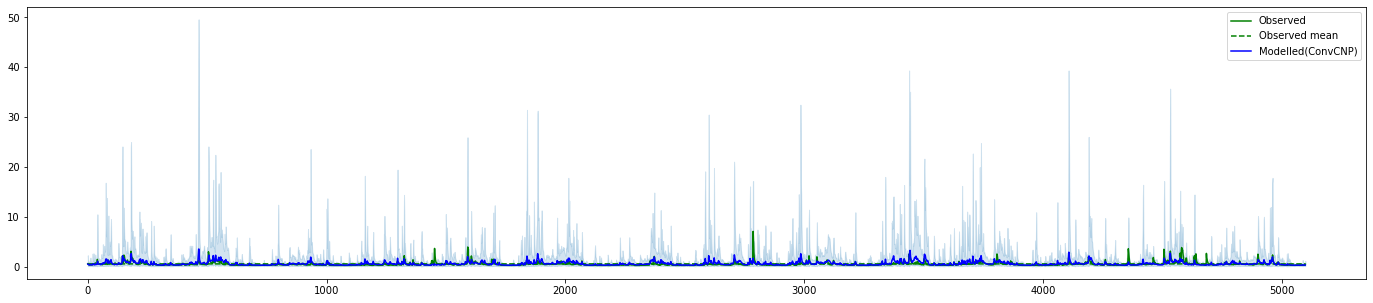

43. Basin hru_04161580 (period: 1997-2010): LL=-0.011 -- NSE=0.358 -- time=19.362


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


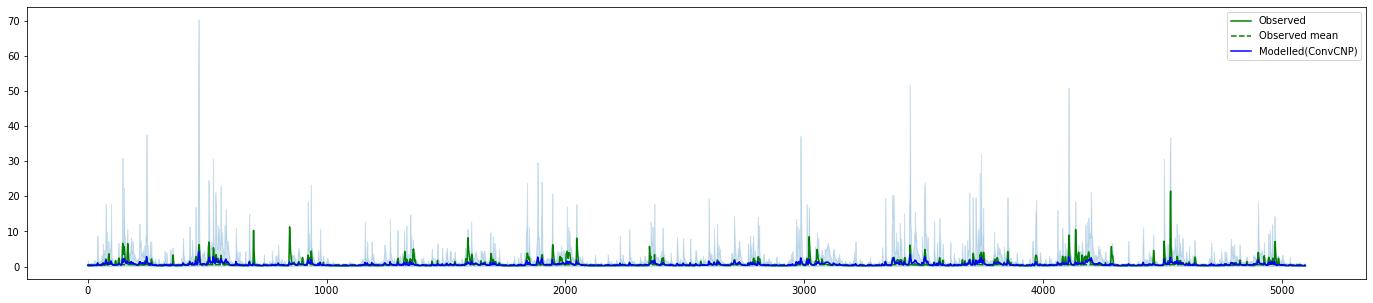

44. Basin hru_04185000 (period: 1997-2010): LL=-0.014 -- NSE=0.593 -- time=19.194


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


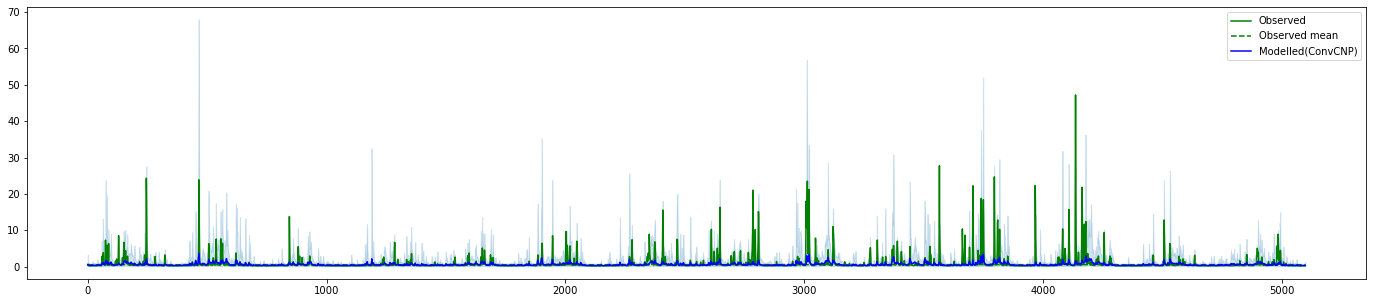

45. Basin hru_04196800 (period: 1997-2010): LL=-0.016 -- NSE=0.508 -- time=20.156


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


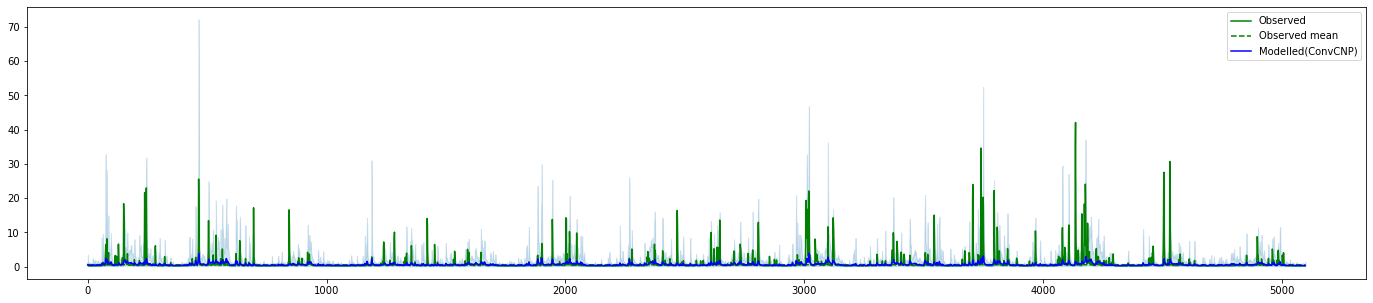

46. Basin hru_04197100 (period: 1997-2010): LL=-0.017 -- NSE=0.472 -- time=19.557


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


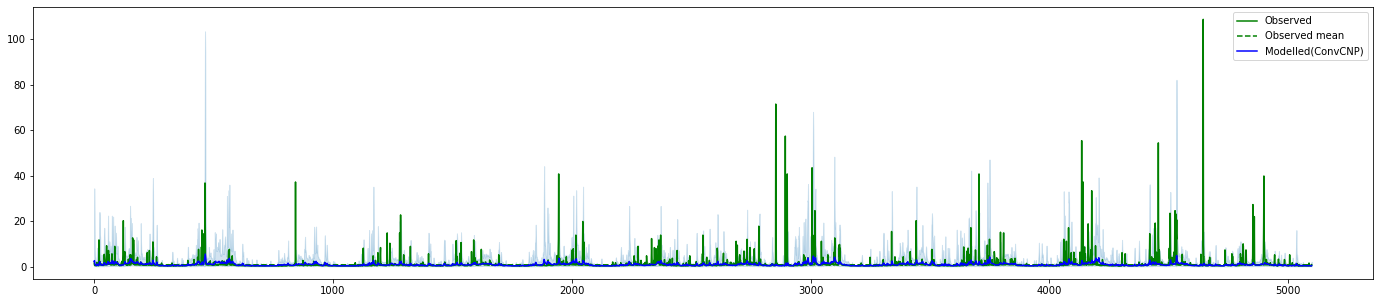

47. Basin hru_04213075 (period: 1997-2010): LL=-0.018 -- NSE=0.433 -- time=19.244


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


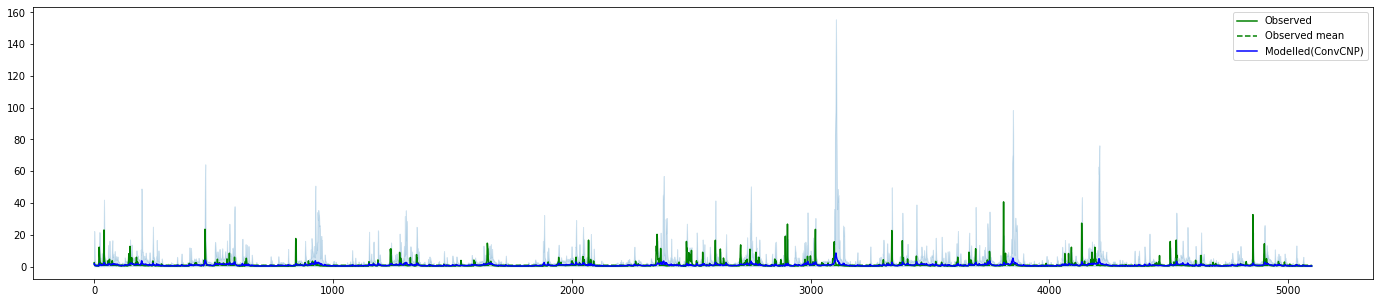

48. Basin hru_04221000 (period: 1997-2010): LL=-0.016 -- NSE=0.526 -- time=19.435


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


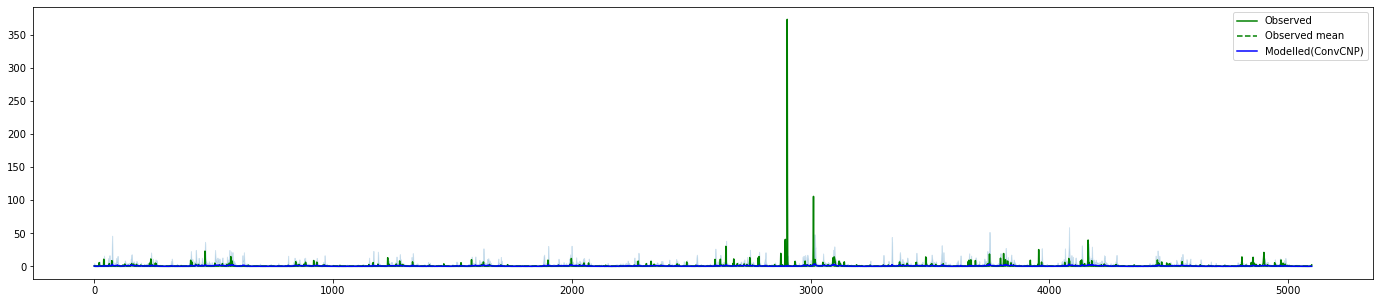

49. Basin hru_03049800 (period: 1997-2010): LL=-0.018 -- NSE=0.425 -- time=19.231


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


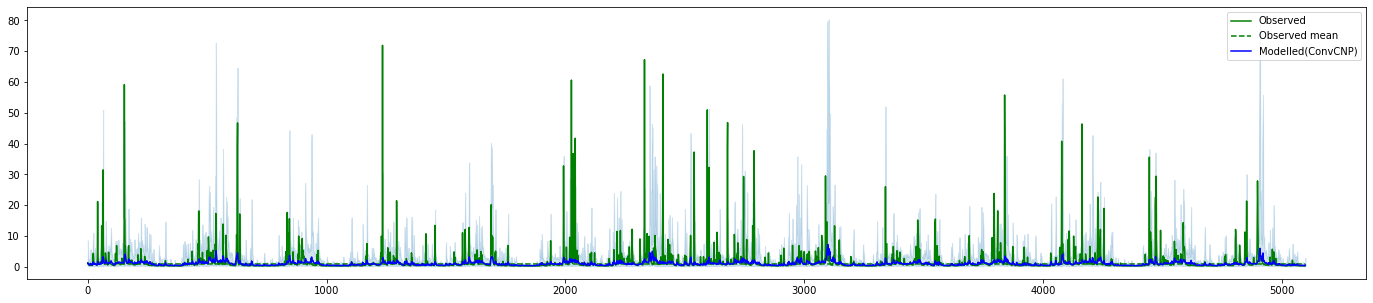

50. Basin hru_03050000 (period: 1997-2010): LL=-0.019 -- NSE=0.577 -- time=19.463


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


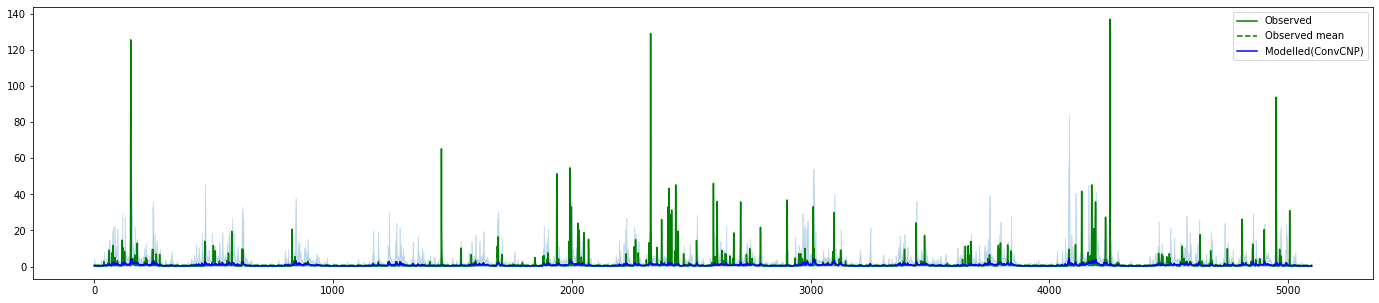

51. Basin hru_03237280 (period: 1997-2010): LL=-0.021 -- NSE=0.407 -- time=19.703


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


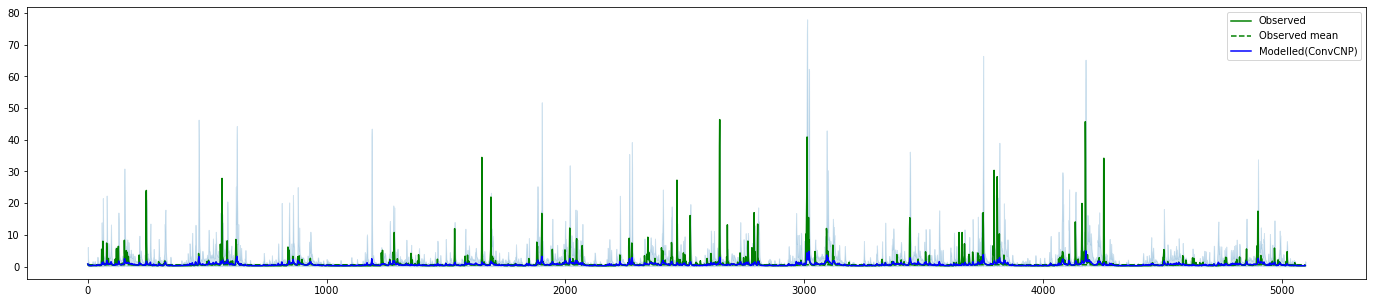

52. Basin hru_03241500 (period: 1997-2010): LL=-0.013 -- NSE=0.589 -- time=19.455


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


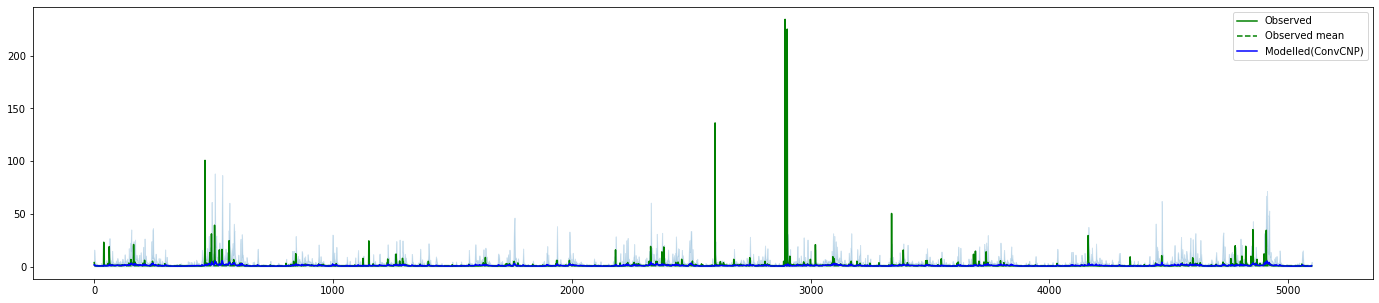

53. Basin hru_03479000 (period: 1997-2010): LL=-0.013 -- NSE=0.619 -- time=19.932


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


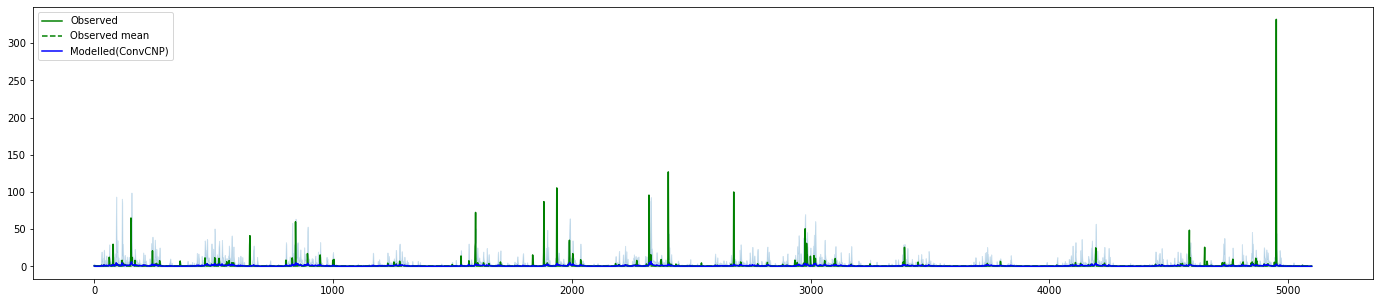

54. Basin hru_03604000 (period: 1997-2010): LL=-0.013 -- NSE=0.614 -- time=19.701


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


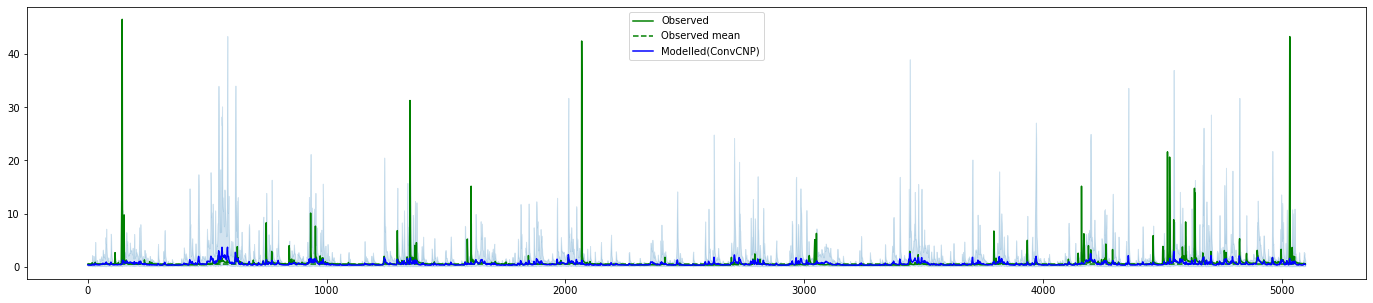

55. Basin hru_05444000 (period: 1997-2010): LL=-0.013 -- NSE=0.181 -- time=19.608


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


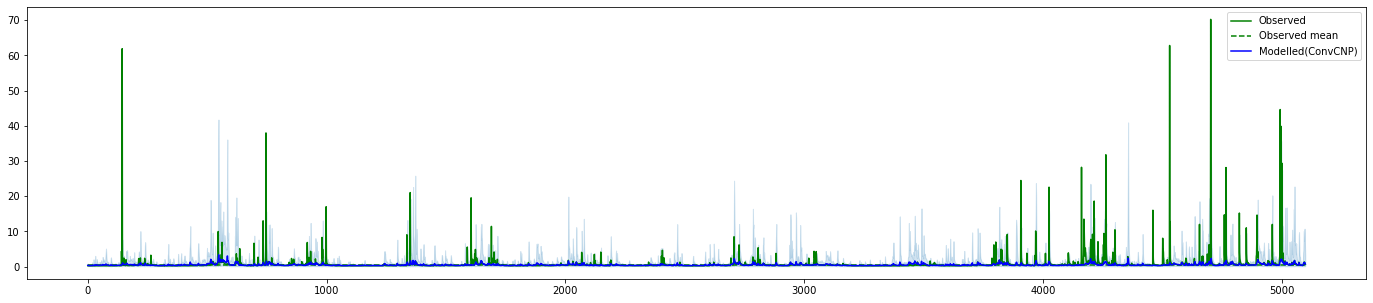

56. Basin hru_05454000 (period: 1997-2010): LL=-0.013 -- NSE=0.424 -- time=19.454


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

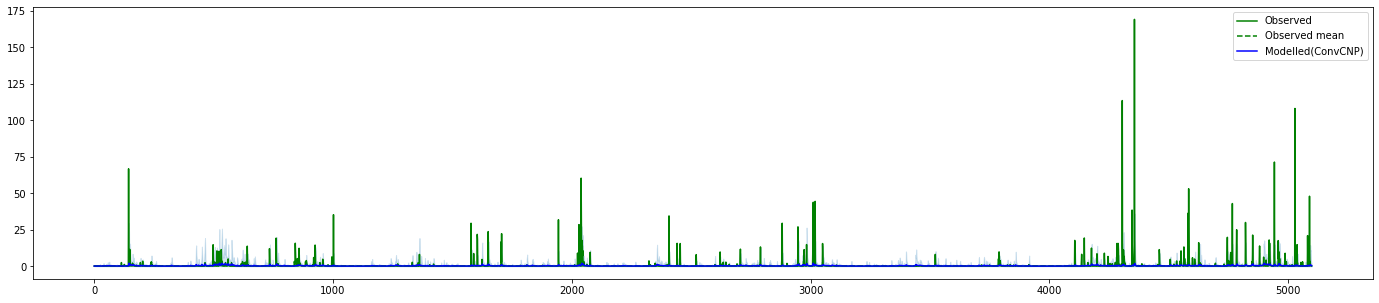

57. Basin hru_05508805 (period: 1997-2010): LL=-0.014 -- NSE=0.334 -- time=20.193


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


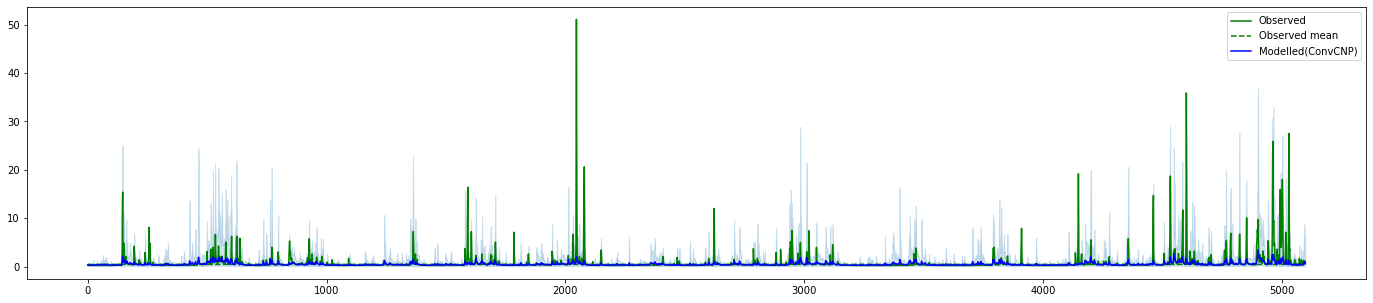

58. Basin hru_05584500 (period: 1997-2010): LL=-0.011 -- NSE=0.563 -- time=19.555


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


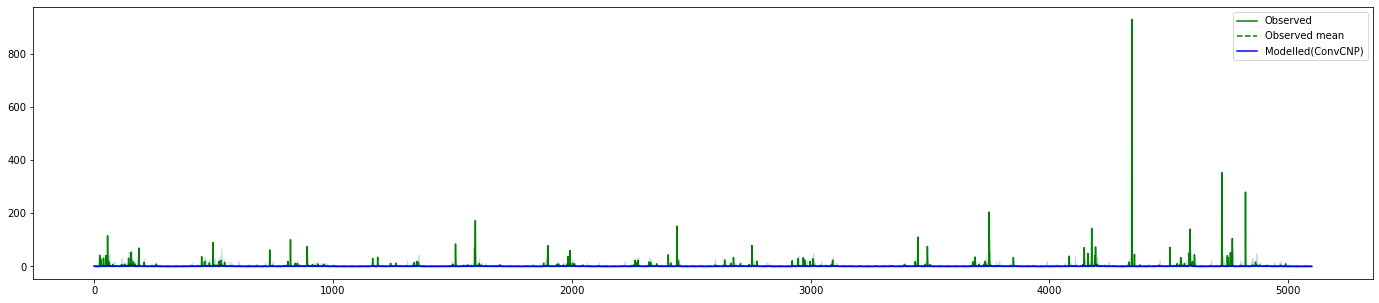

59. Basin hru_07362587 (period: 1997-2010): LL=-0.020 -- NSE=0.485 -- time=19.281


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

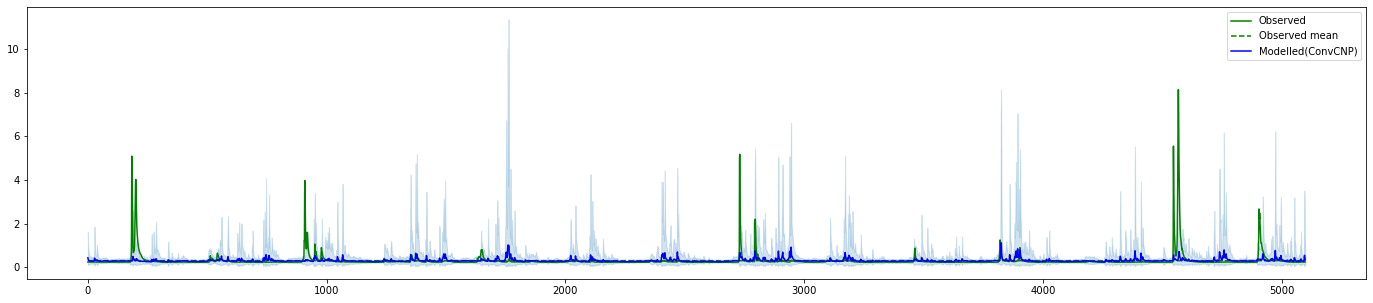

60. Basin hru_05057200 (period: 1997-2010): LL=0.000 -- NSE=0.007 -- time=19.536


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


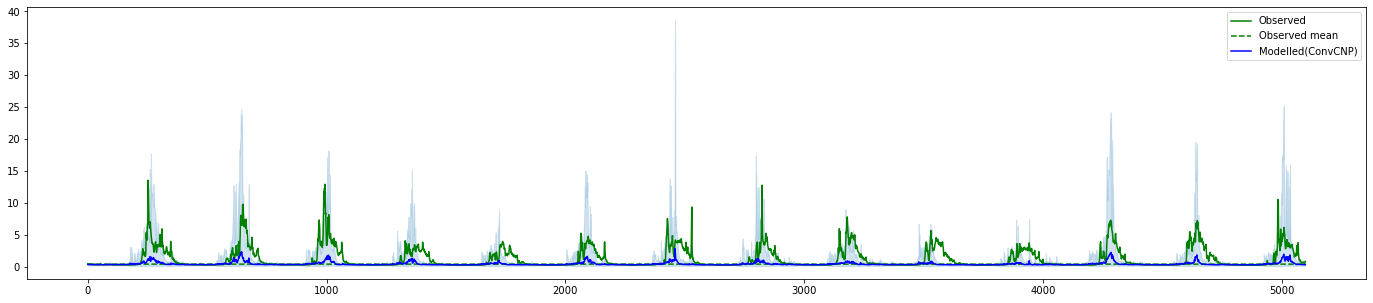

61. Basin hru_06221400 (period: 1997-2010): LL=-0.039 -- NSE=0.132 -- time=20.456


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

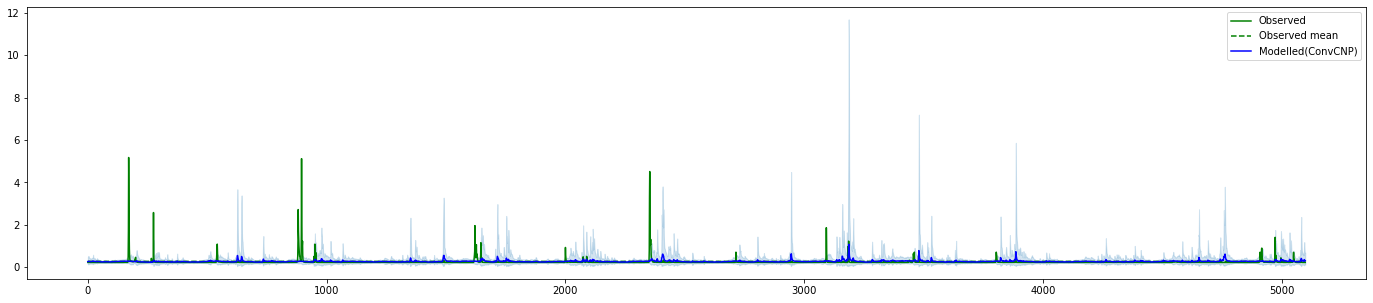

62. Basin hru_06332515 (period: 1997-2010): LL=0.004 -- NSE=-0.633 -- time=19.304


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

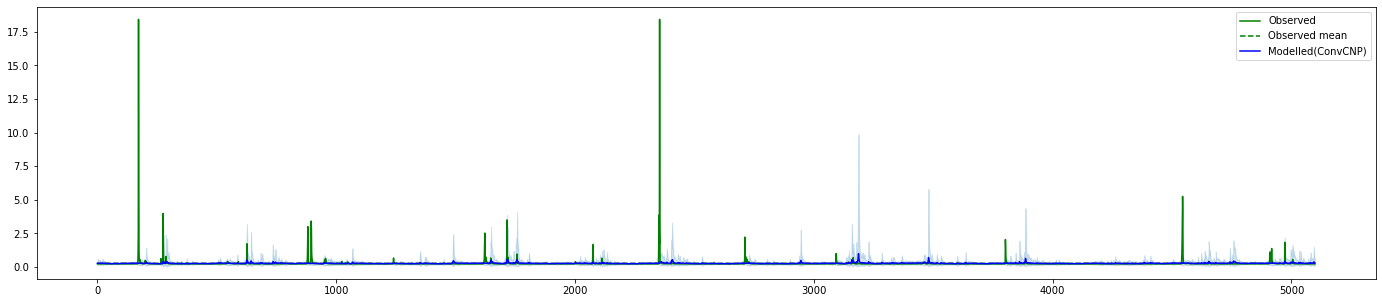

63. Basin hru_06339100 (period: 1997-2010): LL=0.004 -- NSE=-0.154 -- time=19.160


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

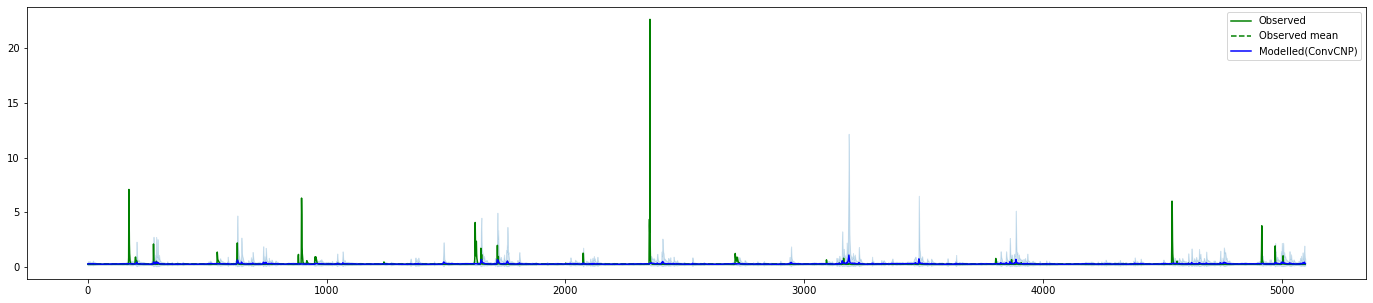

64. Basin hru_06344600 (period: 1997-2010): LL=0.003 -- NSE=-0.146 -- time=20.299


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

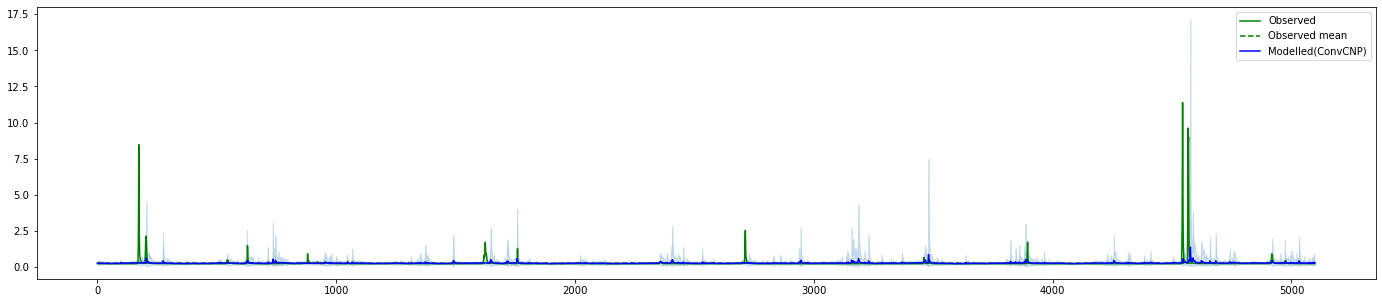

65. Basin hru_06352000 (period: 1997-2010): LL=0.008 -- NSE=-0.111 -- time=19.368


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

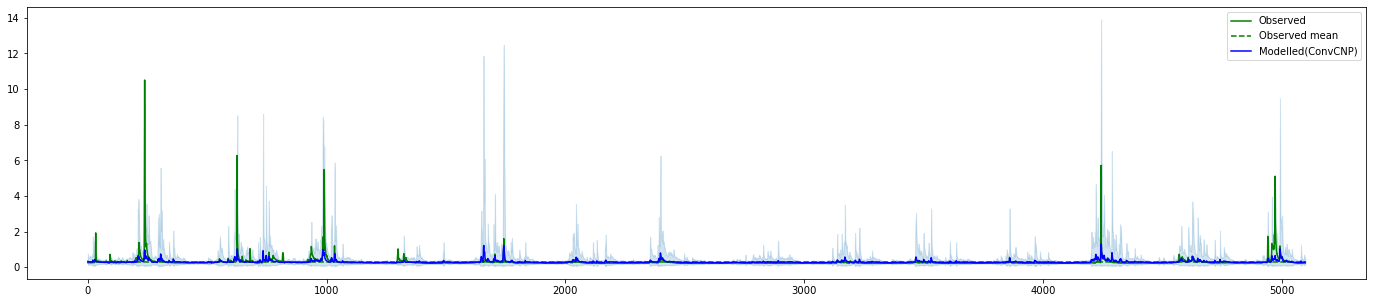

66. Basin hru_06404000 (period: 1997-2010): LL=0.005 -- NSE=0.410 -- time=19.711


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

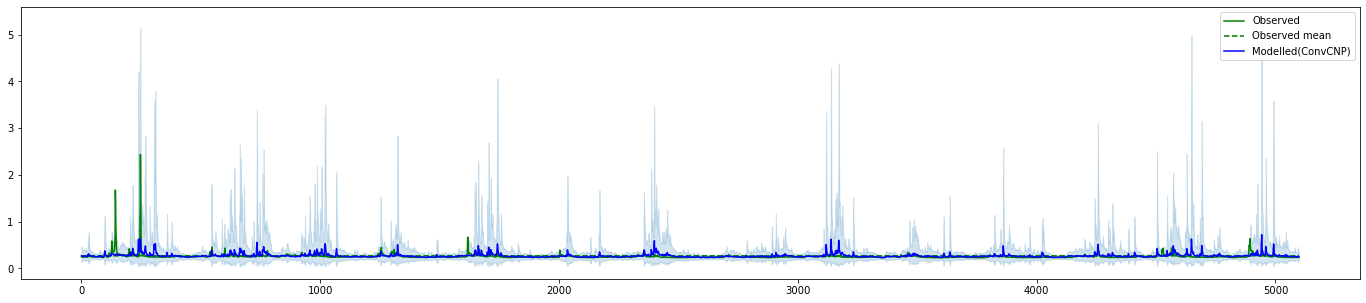

67. Basin hru_06447500 (period: 1997-2010): LL=0.015 -- NSE=-0.362 -- time=19.342


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

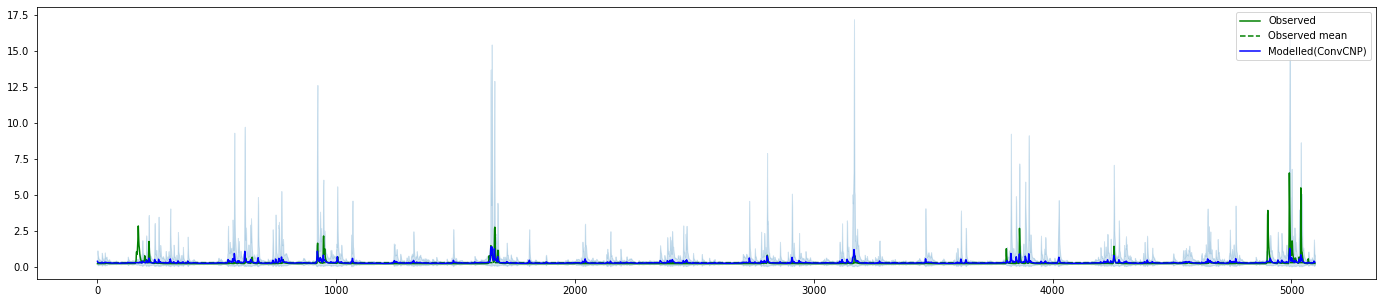

68. Basin hru_06477500 (period: 1997-2010): LL=0.002 -- NSE=-0.065 -- time=19.566


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


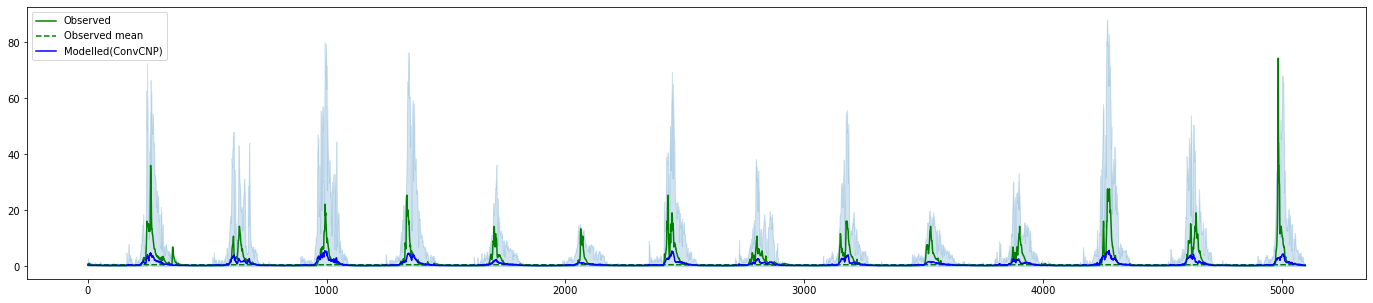

69. Basin hru_06614800 (period: 1997-2010): LL=-0.010 -- NSE=0.718 -- time=19.584


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

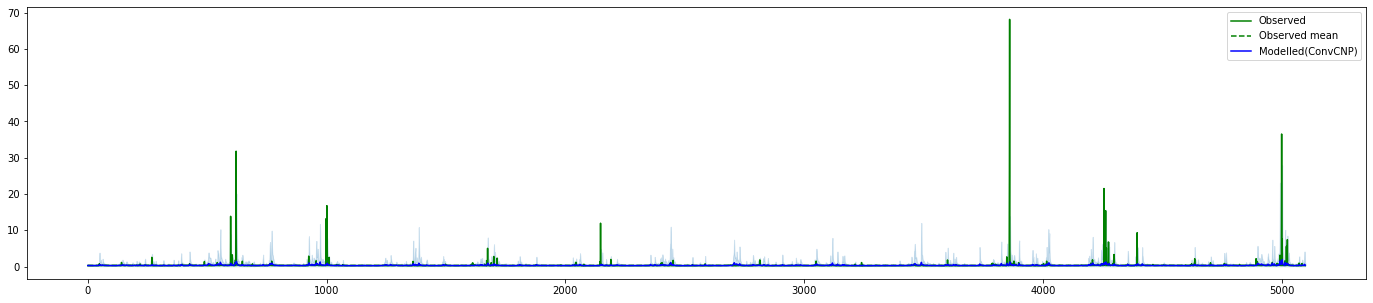

70. Basin hru_06803510 (period: 1997-2010): LL=0.001 -- NSE=0.216 -- time=19.477


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

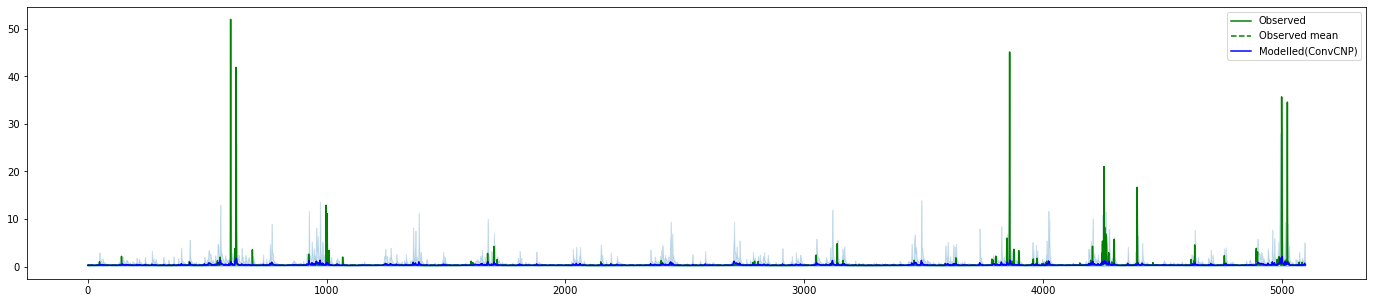

71. Basin hru_06803530 (period: 1997-2010): LL=-0.001 -- NSE=0.189 -- time=20.242


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

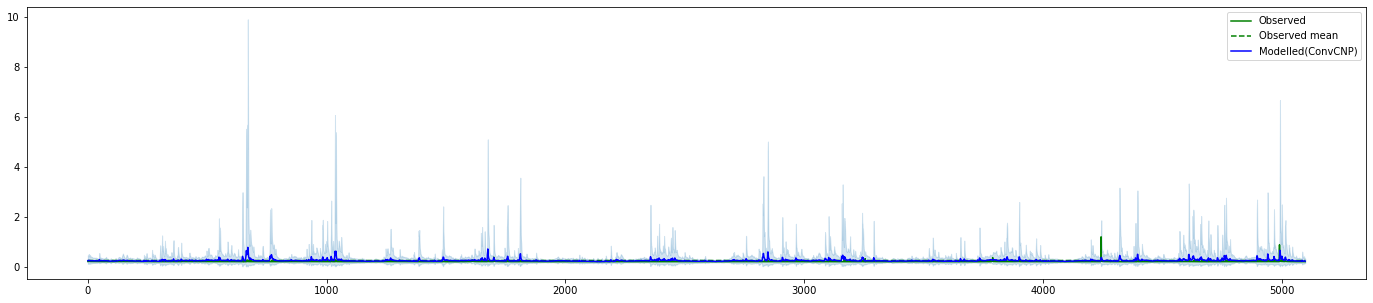

72. Basin hru_06847900 (period: 1997-2010): LL=0.009 -- NSE=-24.728 -- time=19.747


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

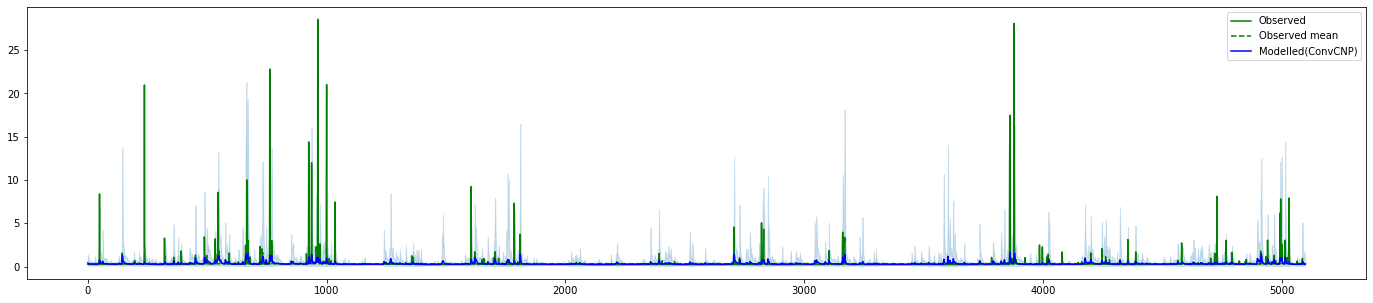

73. Basin hru_06878000 (period: 1997-2010): LL=-0.001 -- NSE=0.351 -- time=19.546


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

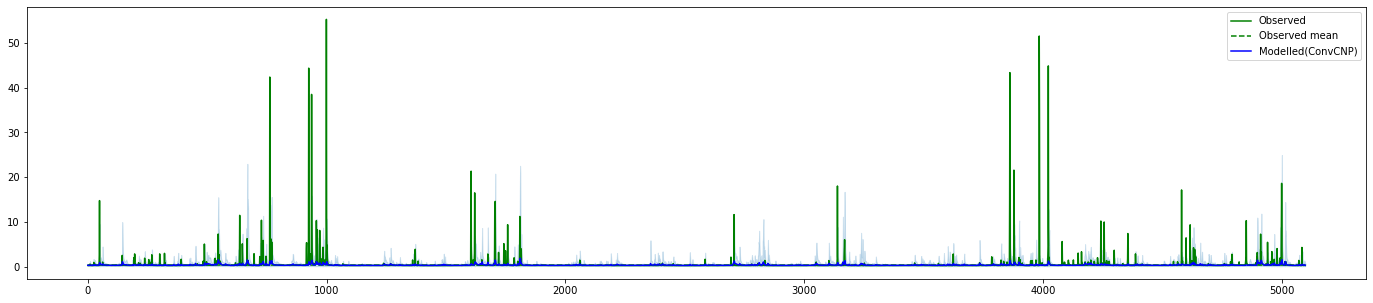

74. Basin hru_06885500 (period: 1997-2010): LL=-0.005 -- NSE=0.384 -- time=19.441


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

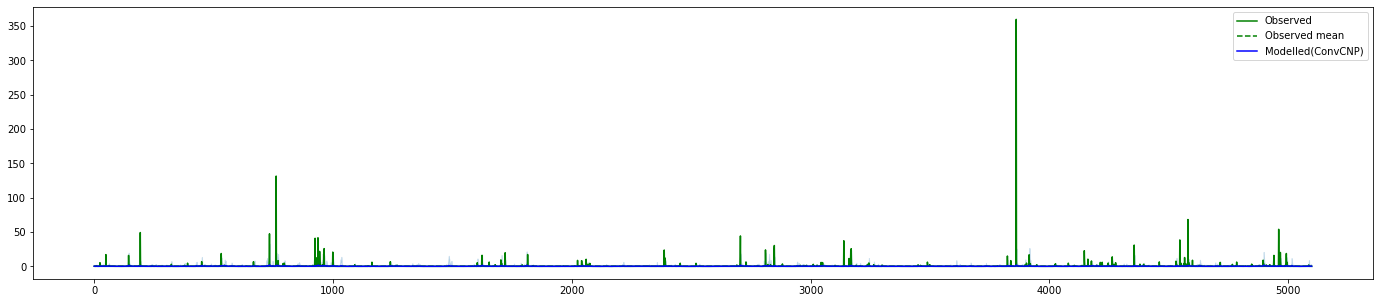

75. Basin hru_06911900 (period: 1997-2010): LL=-0.010 -- NSE=0.340 -- time=19.357


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

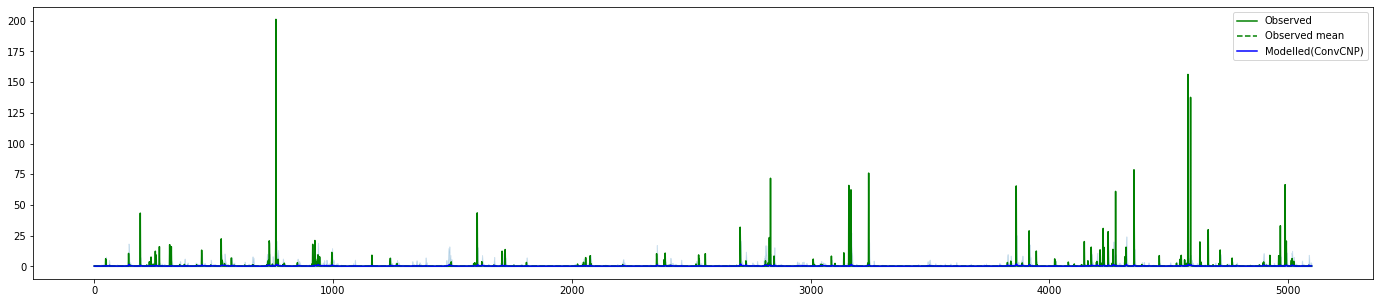

76. Basin hru_07180500 (period: 1997-2010): LL=-0.007 -- NSE=0.374 -- time=19.216


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


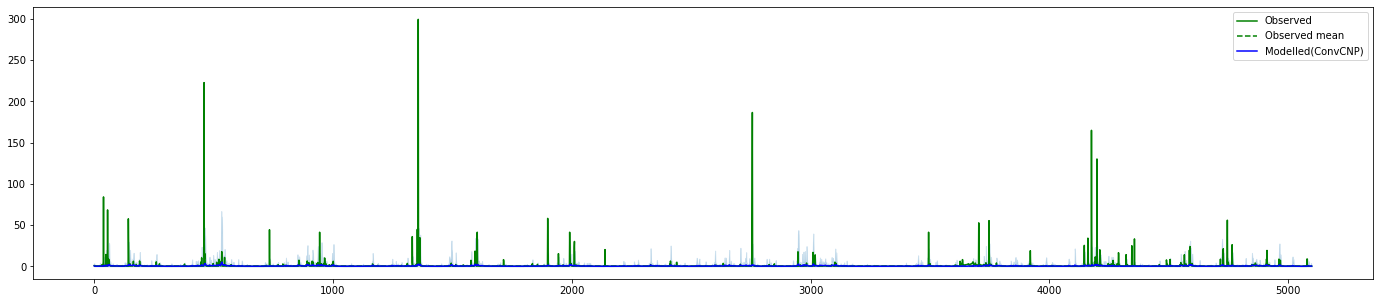

77. Basin hru_07196900 (period: 1997-2010): LL=-0.016 -- NSE=0.470 -- time=20.275


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

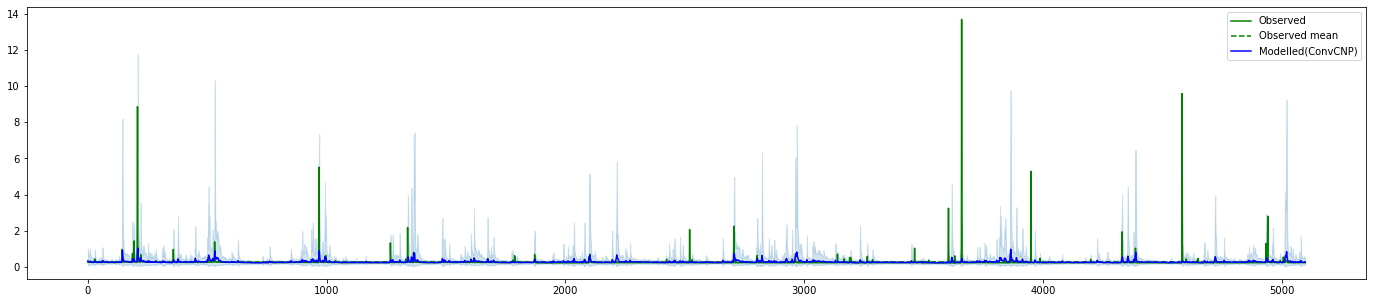

78. Basin hru_07299670 (period: 1997-2010): LL=0.008 -- NSE=-0.259 -- time=19.610


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

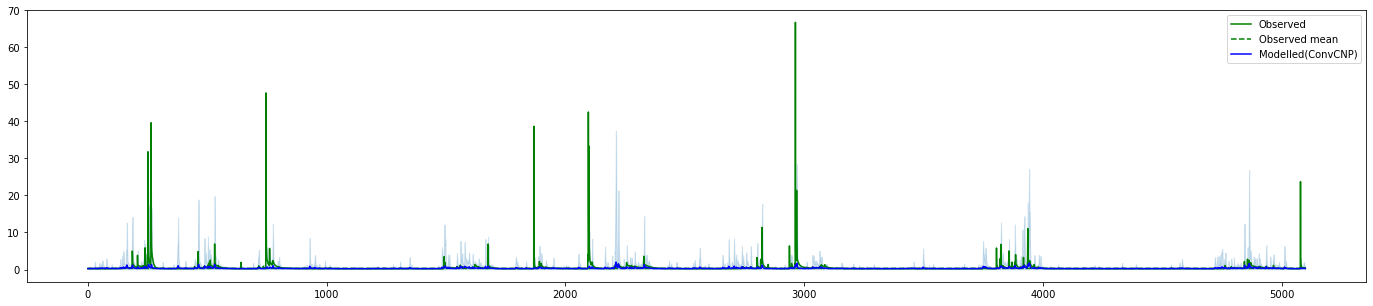

79. Basin hru_08158700 (period: 1997-2010): LL=-0.003 -- NSE=0.446 -- time=19.704


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

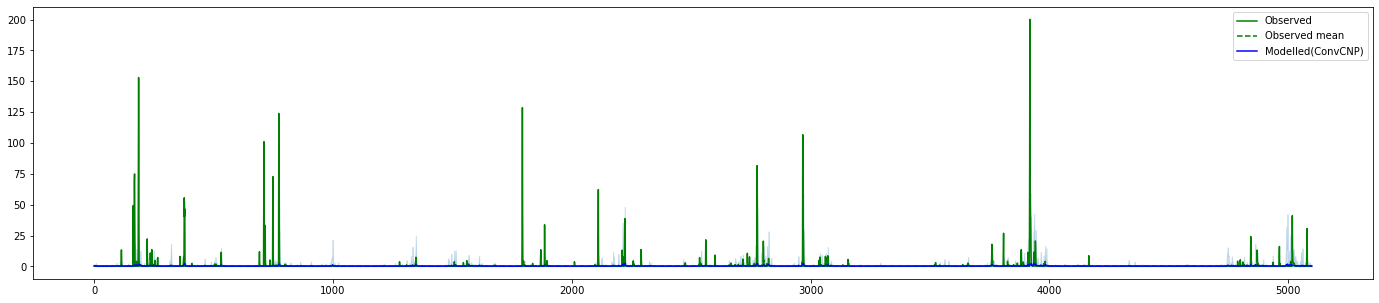

80. Basin hru_08164600 (period: 1997-2010): LL=-0.005 -- NSE=0.413 -- time=19.516


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

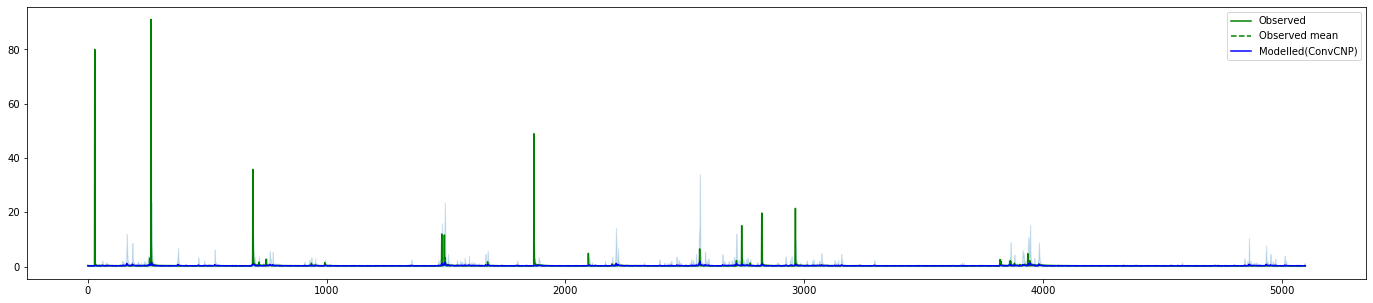

81. Basin hru_08190000 (period: 1997-2010): LL=0.005 -- NSE=0.397 -- time=19.840


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

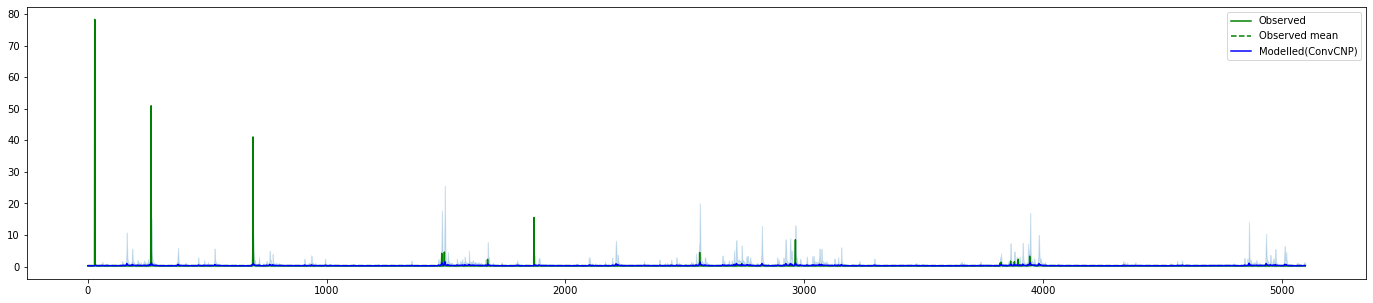

82. Basin hru_08190500 (period: 1997-2010): LL=0.002 -- NSE=-1.293 -- time=20.889


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

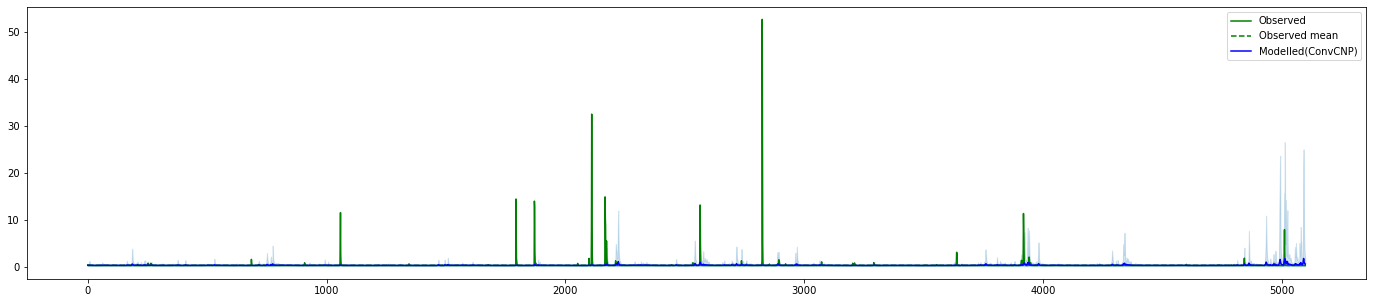

83. Basin hru_08194200 (period: 1997-2010): LL=0.008 -- NSE=-0.044 -- time=19.246


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

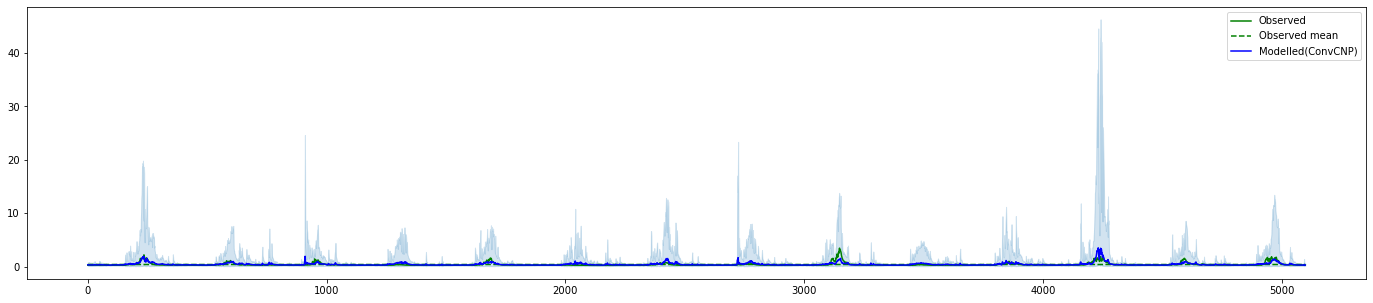

84. Basin hru_08269000 (period: 1997-2010): LL=-0.002 -- NSE=0.496 -- time=19.390


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

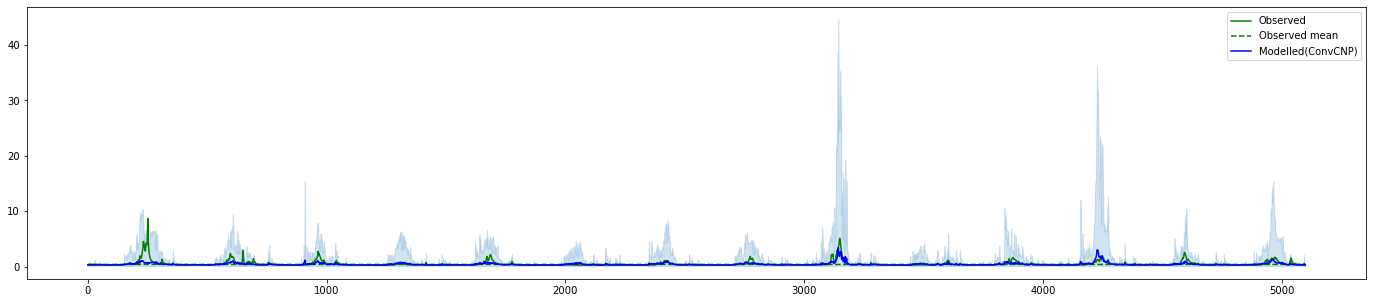

85. Basin hru_08378500 (period: 1997-2010): LL=-0.001 -- NSE=0.605 -- time=19.592


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


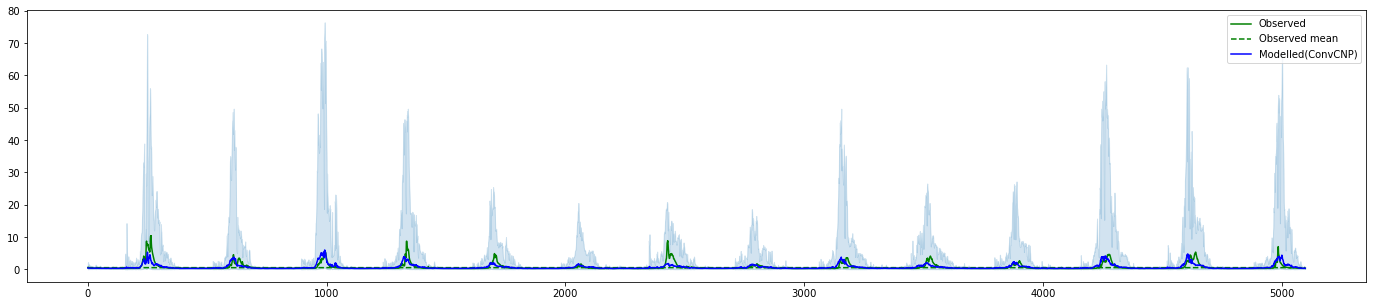

86. Basin hru_09035800 (period: 1997-2010): LL=-0.006 -- NSE=0.714 -- time=19.456


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


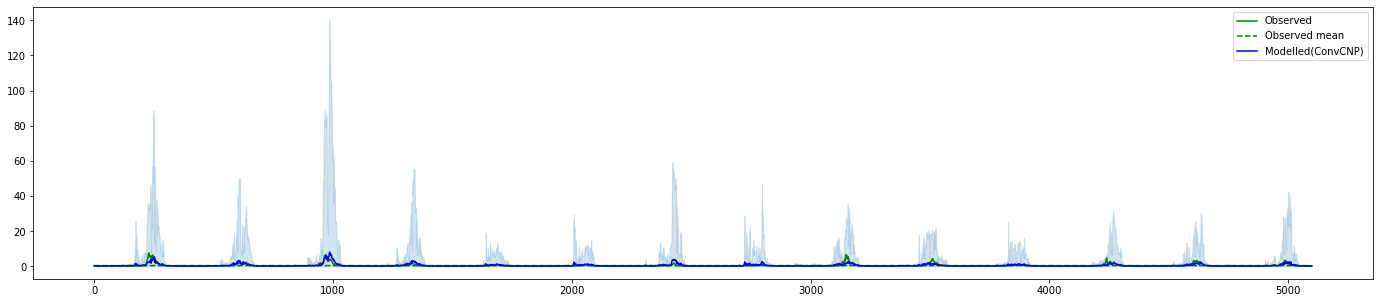

87. Basin hru_09223000 (period: 1997-2010): LL=-0.006 -- NSE=0.648 -- time=19.476


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

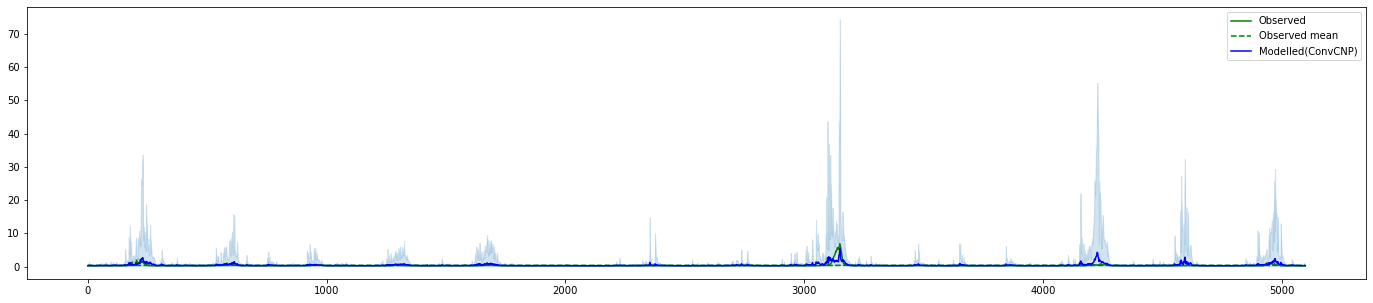

88. Basin hru_09378170 (period: 1997-2010): LL=-0.003 -- NSE=-0.287 -- time=19.396


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

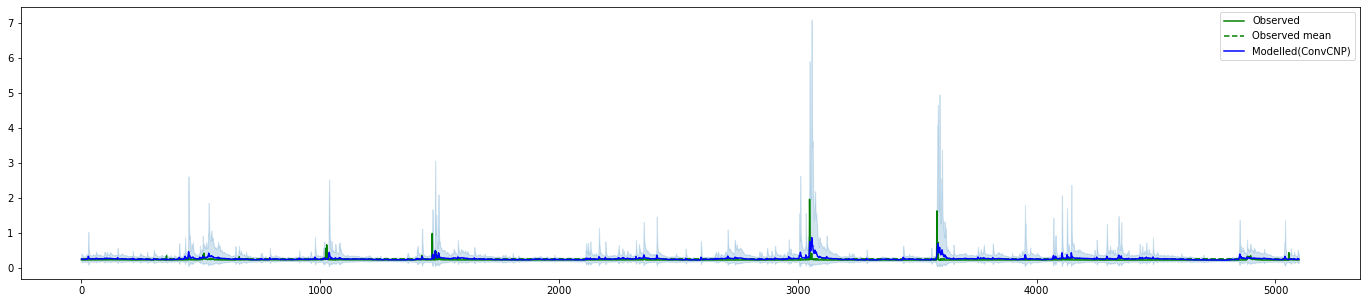

89. Basin hru_09447800 (period: 1997-2010): LL=0.016 -- NSE=-3.397 -- time=19.603


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

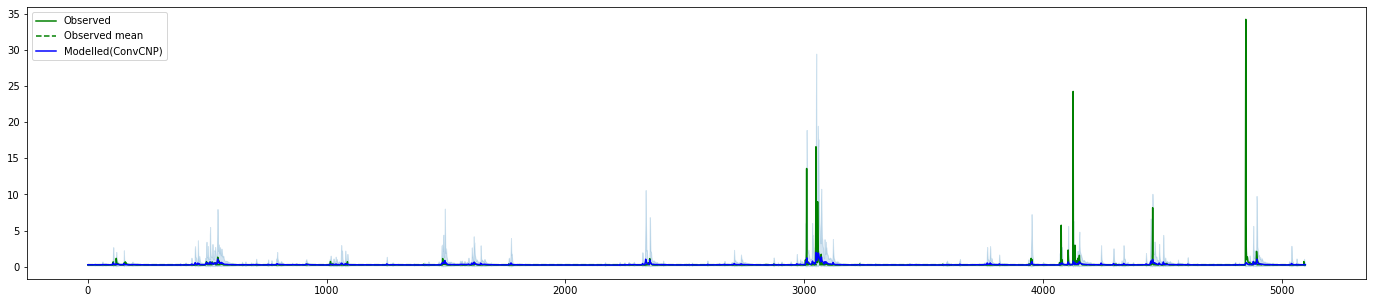

90. Basin hru_09497980 (period: 1997-2010): LL=0.012 -- NSE=0.413 -- time=19.276


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:180: RuntimeWarning: invalid value encountered in log
  qsm1 = np.log(sim[np.round(m1 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:182: RuntimeWarning: invalid value encountered in log
  qom1 = np.log(obs[np.round(m1 * len(obs)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.ro

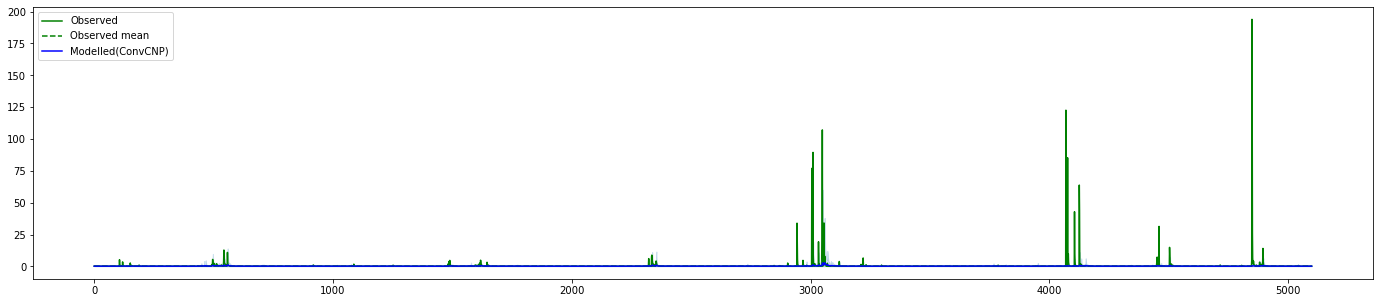

91. Basin hru_09508300 (period: 1997-2010): LL=0.005 -- NSE=0.417 -- time=19.369


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


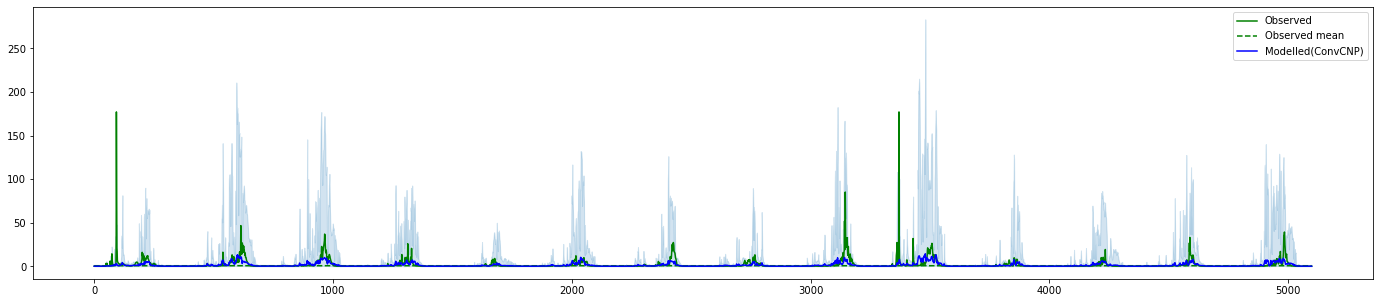

92. Basin hru_10336645 (period: 1997-2010): LL=-0.014 -- NSE=0.701 -- time=20.228


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


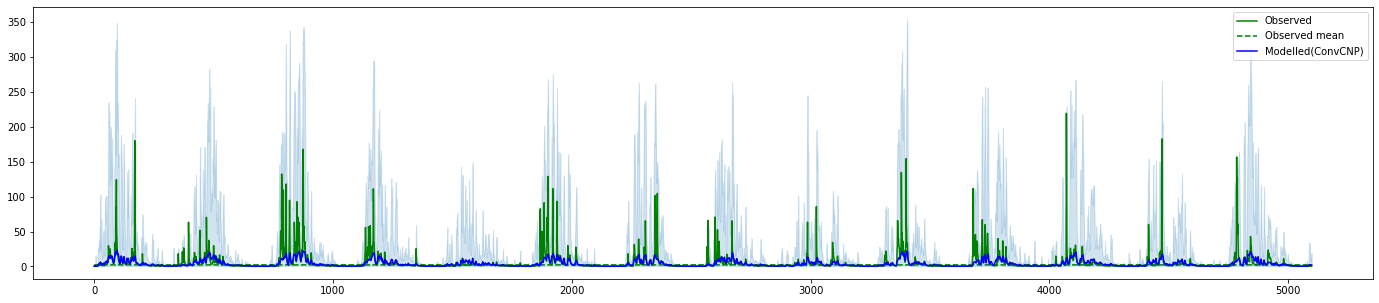

93. Basin hru_12013500 (period: 1997-2010): LL=-0.022 -- NSE=0.782 -- time=19.725


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)


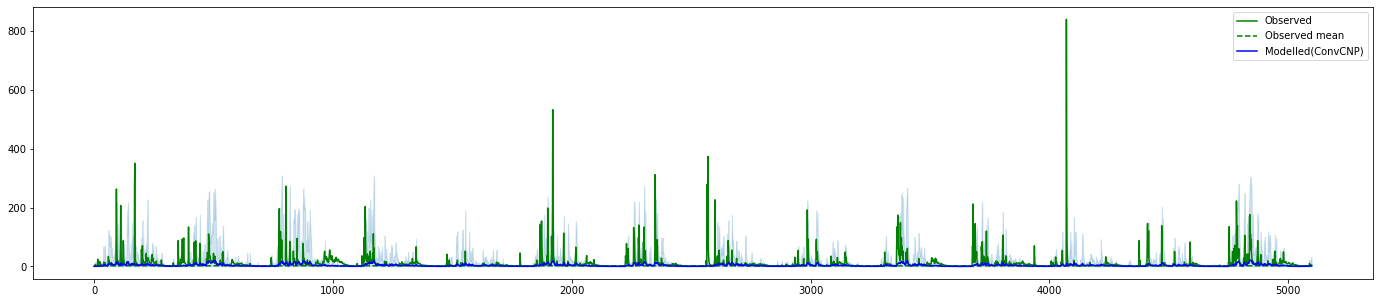

94. Basin hru_12056500 (period: 1997-2010): LL=-0.035 -- NSE=0.173 -- time=19.412


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)


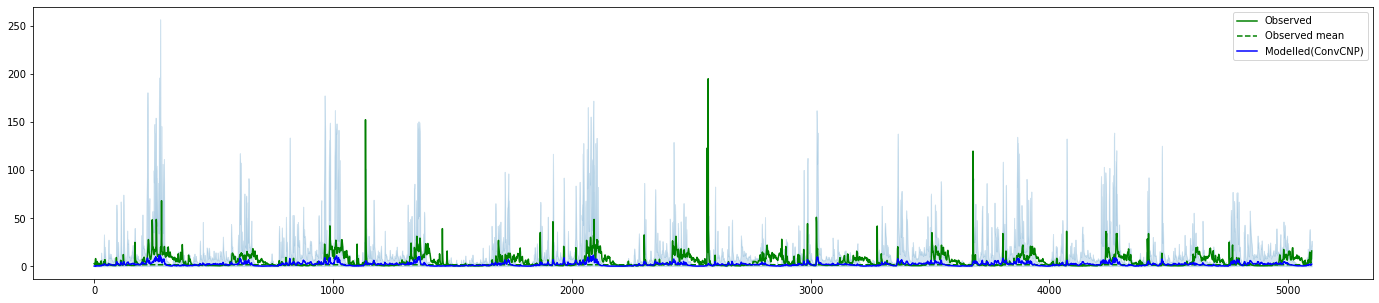

95. Basin hru_12175500 (period: 1997-2010): LL=-0.052 -- NSE=-0.548 -- time=20.151


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


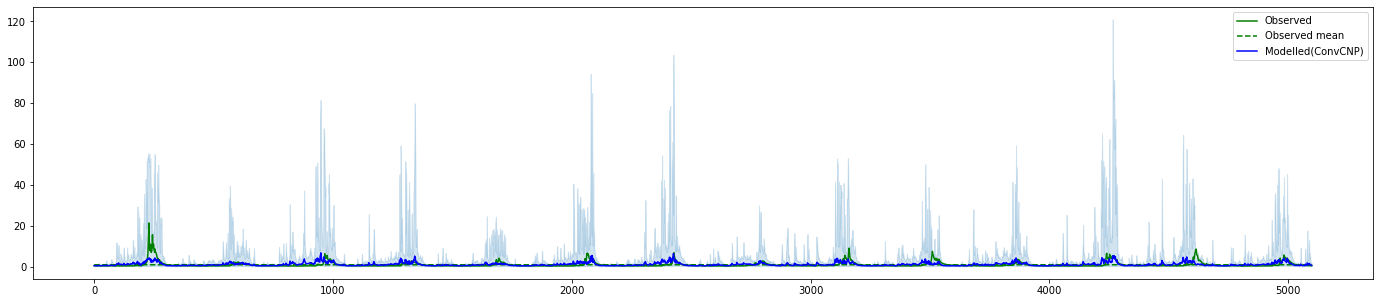

96. Basin hru_12381400 (period: 1997-2010): LL=-0.024 -- NSE=-0.092 -- time=19.458


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


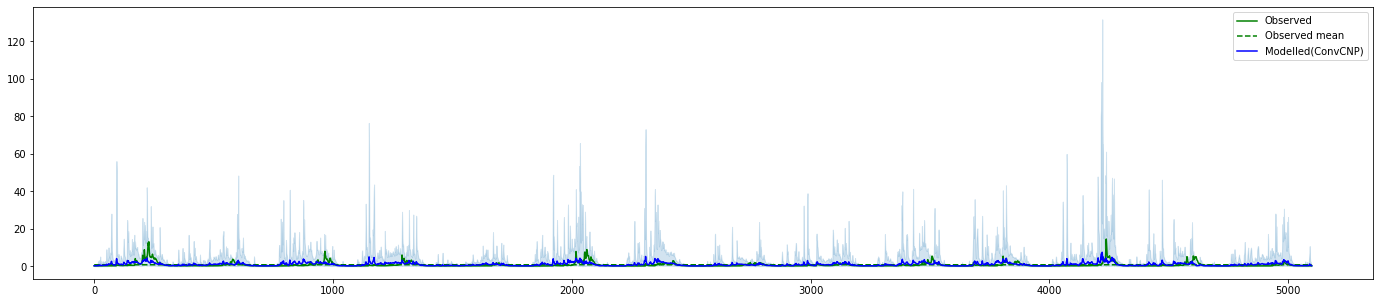

97. Basin hru_12390700 (period: 1997-2010): LL=-0.023 -- NSE=-0.169 -- time=19.503


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)


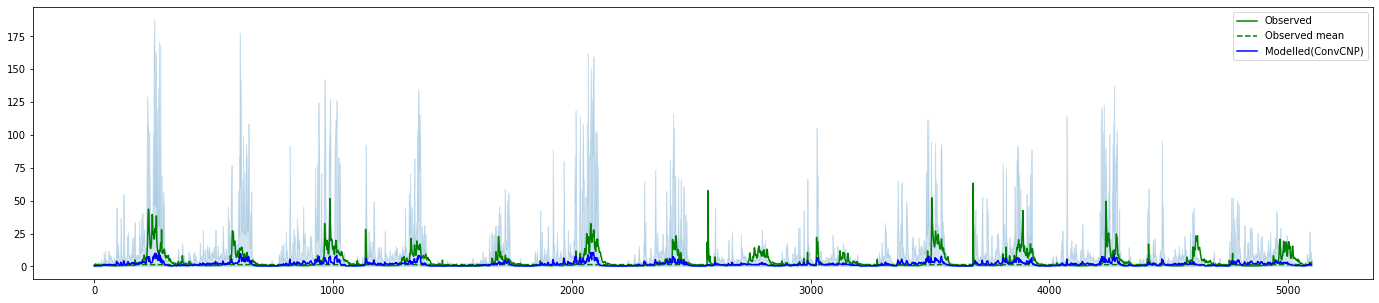

98. Basin hru_12451000 (period: 1997-2010): LL=-0.038 -- NSE=0.107 -- time=19.261


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


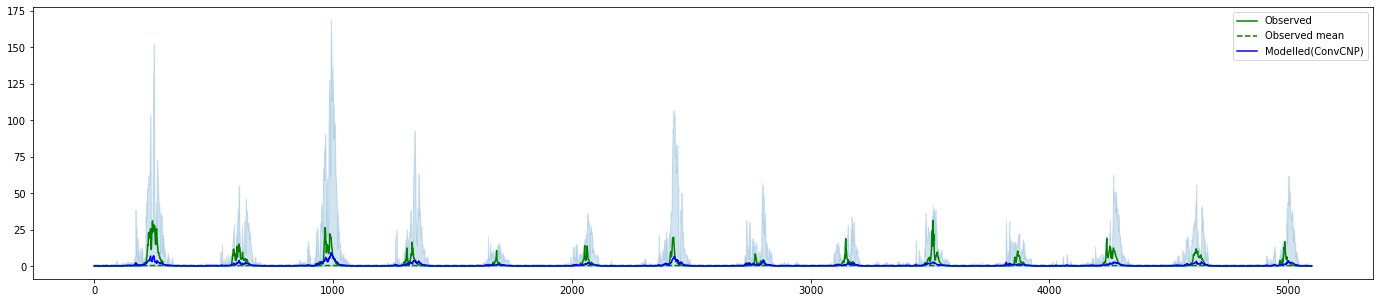

99. Basin hru_13011500 (period: 1997-2010): LL=-0.012 -- NSE=0.673 -- time=19.386


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


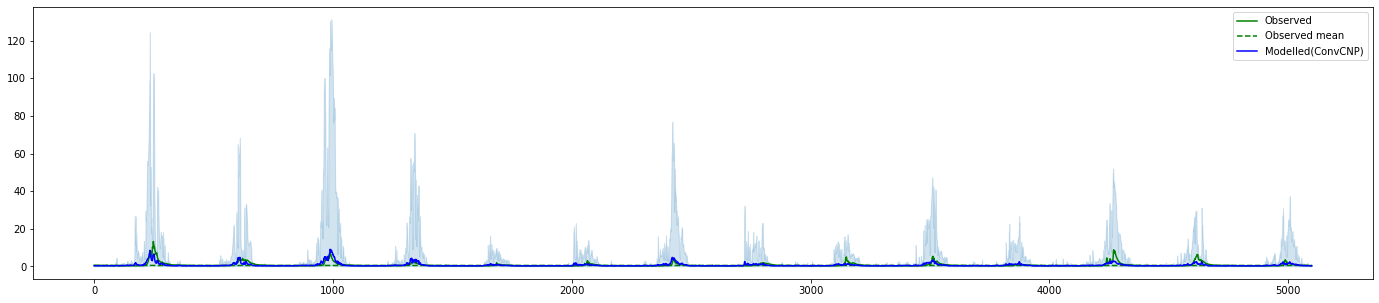

100. Basin hru_13018300 (period: 1997-2010): LL=-0.013 -- NSE=0.498 -- time=20.270


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


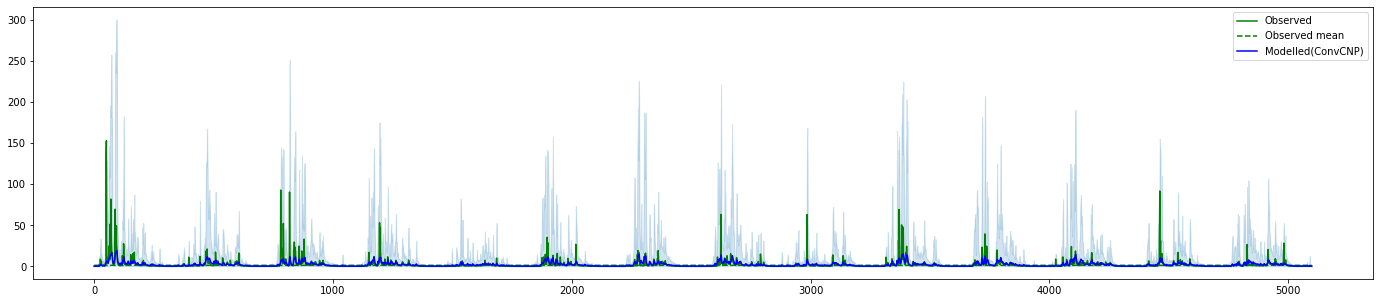

101. Basin hru_14154500 (period: 1997-2010): LL=-0.019 -- NSE=0.743 -- time=19.454


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


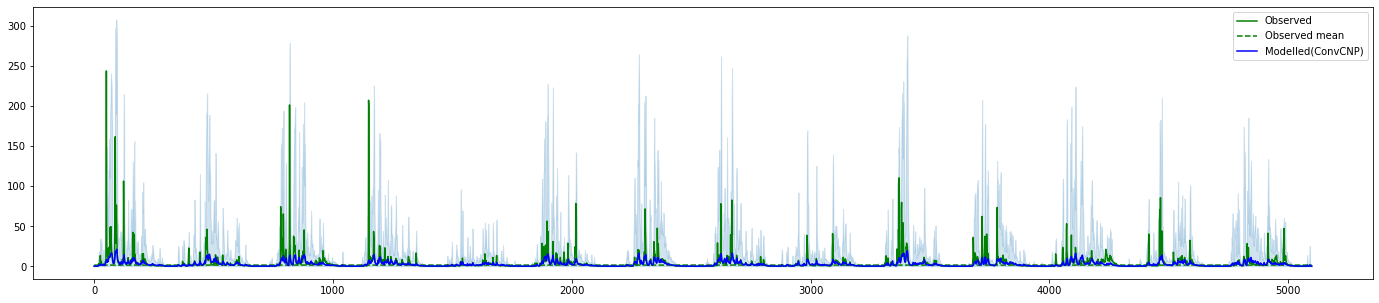

102. Basin hru_14185000 (period: 1997-2010): LL=-0.017 -- NSE=0.861 -- time=19.511


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)


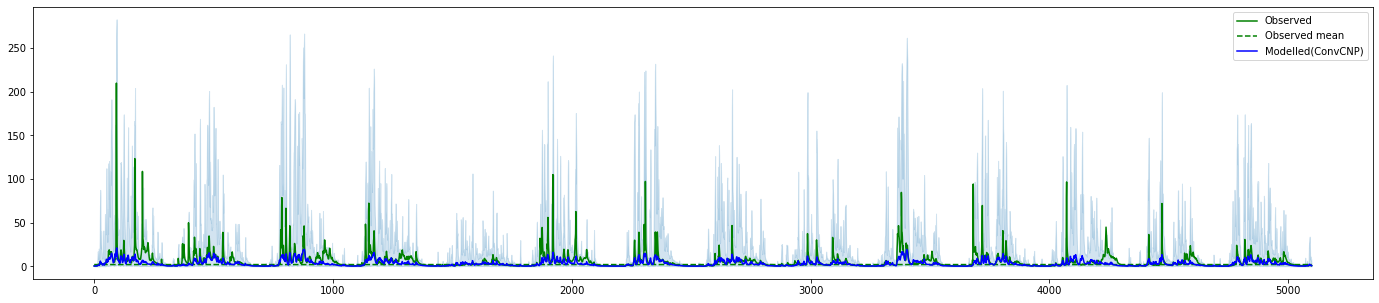

103. Basin hru_14216500 (period: 1997-2010): LL=-0.024 -- NSE=0.628 -- time=19.756


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


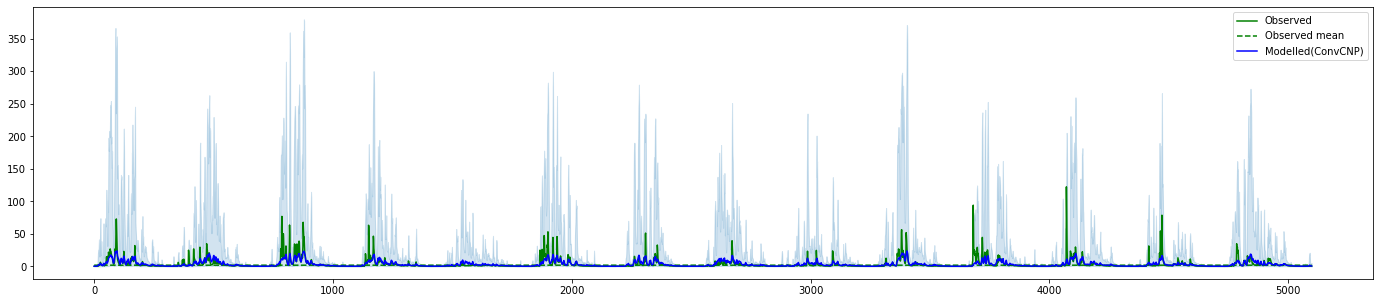

104. Basin hru_14301000 (period: 1997-2010): LL=-0.021 -- NSE=0.777 -- time=19.569


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


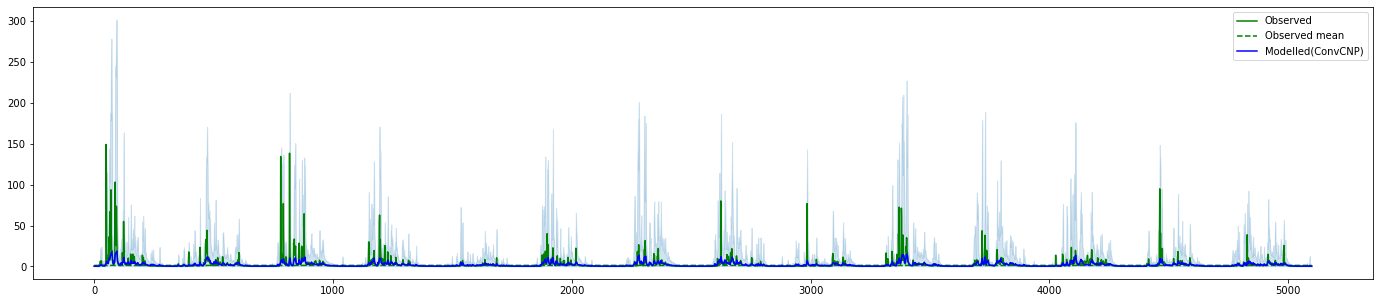

105. Basin hru_14316700 (period: 1997-2010): LL=-0.016 -- NSE=0.820 -- time=19.379


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:183: RuntimeWarning: invalid value encountered in log
  qom2 = np.log(obs[np.round(m2 * len(obs)).astype(int)] + 1e-6)


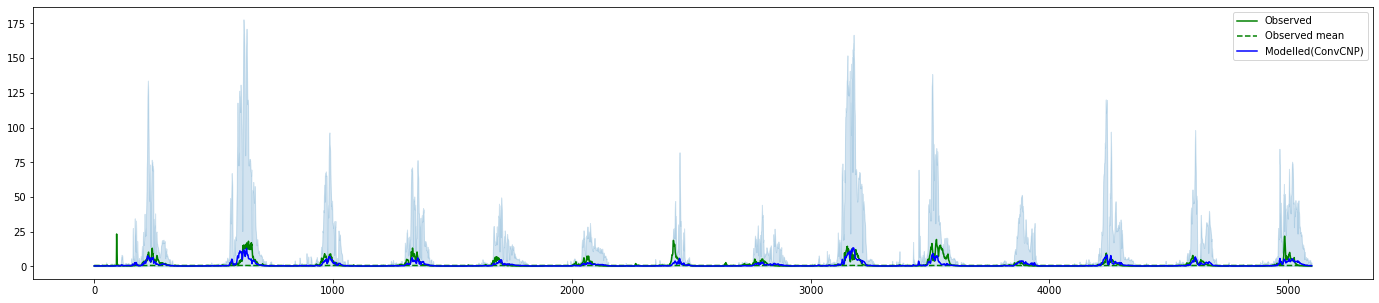

106. Basin hru_11230500 (period: 1997-2010): LL=-0.014 -- NSE=0.722 -- time=19.138


/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:285: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:286: RuntimeWarning: invalid value encountered in log
  sim = np.log(sim + 1e-6)
/home/donal/Documents/mg963/MResProject/convcnp/convcnp/metrics.py:181: RuntimeWarning: invalid value encountered in log
  qsm2 = np.log(sim[np.round(m2 * len(sim)).astype(int)] + 1e-6)


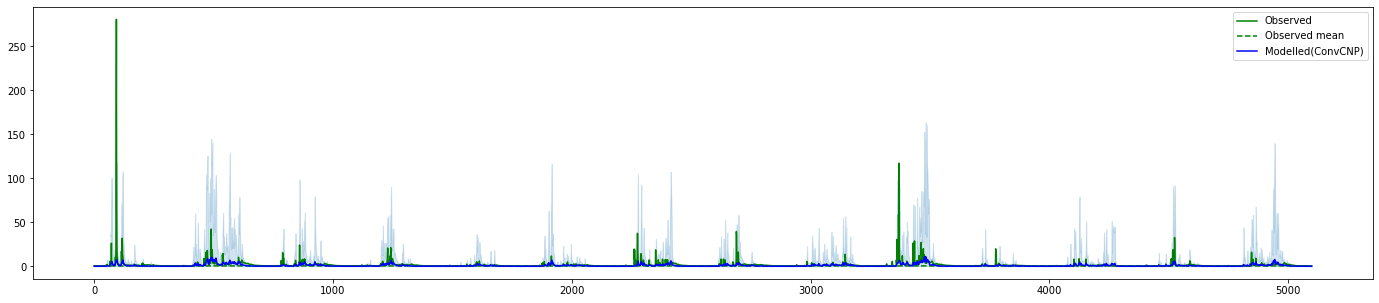

107. Basin hru_11381500 (period: 1997-2010): LL=-0.084 -- NSE=-0.086 -- time=19.523


In [94]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 10
gen_365 = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            concat_static_features = concat_static_features,
                                            extrapolate = True,
                                            timeslice = 365,
                                            min_train_points=364,
                                            min_test_points=1,
                                            max_train_points=364,
                                            max_test_points=1,
                                            device='cpu')

out = np.array([])
out_2 = np.array([])

# Compute average task log-likelihood.
basins = df_test['hru08'].unique().tolist()
#basins = ['hru_01030500','hru_01047000']
print(len(basins))
b=0
for basin in basins[:]:
    
    b+=1
    
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    rnum = RunningAverage()
    rden = RunningAverage()
    model.eval()
    start = time.time()
    
    pred_mu = np.array([])
    pred_sigma = np.array([])
    pred_loc = np.array([])
    pred_scale = np.array([])
    observations = np.array([])
    DOY = np.array([])
    YR = np.array([])
    HRU = np.array([])
    
    alpha_nse = np.array([])
    beta_nse = np.array([])
    nse_index = np.array([])
    fhv = np.array([])
    flv = np.array([])
    fms = np.array([])
    
    with torch.no_grad():    
        years = df_test['YR'][df_test['hru08']==basin].unique().tolist()
        years = sorted(years)[1:]
        
        """duration = 1
        y = np.random.randint(len(years)-duration)
        for year in years[y:y+duration]:"""
        
        testtime_dataloader = DataLoader(dataset=HydroTestDataset(gen_365,years=years,basin=basin),
                                         batch_size=1, num_workers=16, pin_memory=True)
        
        for step, task in enumerate(testtime_dataloader):
            
            torch.cuda.empty_cache()
            
            task = loaded_task(task,device='cpu')
            
            year=years[step]
        
        #for year in years[:]:
        #    task = gen_365.generate_test_task(year,basin)
            
            chunk_size = 50
            chunks = np.arange(0, task['x_context'].shape[0],chunk_size)
            
            #minitask = task.copy()
            #minitask = loaded_task(minitask)
            
            for i in range(len(chunks)):
                
                torch.cuda.empty_cache()
                                
                if i+1 == len(chunks):
                    s = chunks[i]
                    e = task['x'].shape[0]
                else:
                    s = chunks[i]
                    e = chunks[i+1]

                minitask = {}
                for k,v in task.items():
                    minitask[k] = task[k][s:e]
                
                minitask = loaded_task(minitask)
                
                minibatch_size = minitask['x_context'].shape[0]
                
                y_mean, y_std = model(minitask['x_context'], minitask['y_context'], 
                                      minitask['x_target'],minitask['y_att'], 
                                      minitask['feature'],minitask['m'],
                                      static_masking_rate=0,
                                      embedding=feature_embedding_flag)
                
                #print(f'{step}, {basin}, {year}')
                
                if dist == 'gaussian':
                    obj = -gaussian_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                elif dist == 'gamma':
                    obj = -gamma_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                
                obj_nse = NSE.nse_tensor_batch(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']),rev_transform_tensor(y_mean))

                if dist == 'gamma':
                    y_loc = y_mean
                    y_scale = y_std
                    g_mean = torch.distributions.gamma.Gamma(y_mean, y_std).mean
                    g_var = torch.distributions.gamma.Gamma(y_mean, y_std).variance
                    y_mean = g_mean
                    y_std = torch.sqrt(g_var)

                num = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(y_mean))
                den = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']))

                #print(obj.item(), obj_nse.item(), num.item(), den.item())
                #print(minitask['y_target'].shape)

                ravg.update(obj.item() / minibatch_size, minibatch_size)
                ravg_nse.update(obj_nse.item() / minibatch_size, minibatch_size)
                rnum.update(num.item(), minibatch_size)
                rden.update(den.item(), minibatch_size)

                observations = np.append(observations, to_numpy(minitask['y_target']))
                pred_mu = np.append(pred_mu, to_numpy(y_mean))
                pred_sigma = np.append(pred_sigma, to_numpy(y_std))
                
                if dist=='gamma':
                    pred_loc = np.append(pred_loc, to_numpy(y_loc))
                    pred_scale = np.append(pred_scale, to_numpy(y_scale))
                    
                #DOY = np.append(DOY, np.arange(s+1,e+1))
                DOY = np.append(DOY, np.arange(1,minibatch_size+1))
                YR = np.append(YR, np.ones(minibatch_size)*year)
                HRU = np.append(HRU, np.array([basin] * minibatch_size))
                
            #print(f'{step}, {basin}, {year}')
                
        alpha_nse = np.append(alpha_nse, calc_alpha_nse(observations,pred_mu))
        beta_nse = np.append(beta_nse, calc_beta_nse(observations,pred_mu))
        nse_index = np.append(nse_index, calc_nse(observations,pred_mu))
        fhv = np.append(fhv, calc_fdc_fhv(observations,pred_mu))
        flv = np.append(flv, calc_fdc_flv(observations,pred_mu))
        fms = np.append(fms, calc_fdc_fms(observations,pred_mu))    
            
        out_basin = np.transpose(np.vstack((HRU,YR,DOY,observations,pred_mu,pred_sigma)))
        out_basin_2 = np.transpose(np.vstack((alpha_nse,beta_nse,nse_index,fhv,flv,fms)))
        
        fig = plt.figure(figsize=(24, 5))
        
        x = np.arange(len(observations))
        
        # Plot model predictions.
        plt.plot(x,rev_transform(observations), label='Observed', color='green')
        plt.plot(x,rev_transform(np.ones(len(pred_mu))*pred_mu.mean()), label='Observed mean', linestyle='dashed', color='green')
        plt.plot(x,rev_transform(pred_mu), label='Modelled(ConvCNP)', color='blue')
        
        if dist=='gaussian':
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale)
            p95 = scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale)
            plt.fill_between(x,
                            rev_transform(p05),
                            rev_transform(p95),
                            color='tab:blue', alpha=0.2)
        
        plt.legend()
        plt.show()

        nse_2 = 1 - rnum.avg/rden.avg
        elapsed = time.time() - start        
        
        #print(f'{b}. Basin {basin} (period: {years[y]}-{years[y+duration]}): LL=%.3f -- NSE=%.3f -- time=%.3f' % (-ravg.avg, calc_nse(observations,pred_mu), elapsed))
        print(f'{b}. Basin {basin} (period: {years[1]}-{years[-1]}): LL=%.3f -- NSE=%.3f -- time=%.3f' % (-ravg.avg, calc_nse(observations,pred_mu), elapsed))
    
    if out.shape[0]!=0:
        out = np.vstack((out,out_basin))
        out_2 = np.vstack((out_2,out_basin_2))
    else:
        out = out_basin
        out_2 = out_basin_2

In [95]:
df_output = pd.DataFrame(out,columns=['HRU','YR','DOY','OBS_RUN','MOD_RUN_MU','MOD_RUN_SIGMA'])
df_output_2 = pd.DataFrame(out_2, columns=['alpha_nse','beta_nse','nse_index','fhv','flv','fms'])

In [96]:
PATH = '_experiments/2020-07-30_19-55-44_k5fold-01-gaussian-log-rainfallboxcox-staticfs-after-encoder-unet'
df_output.to_csv(os.path.join(PATH,f'results_model_best_epoch_56.csv'),index=False)
df_output_2.to_csv(os.path.join(PATH,f'metrics_model_best_epoch_56.csv'),index=False)

In [97]:
"""df_output_test_both_40basins = df_output.copy()
df_output_test_both_40basins_2 = df_output_2.copy()"""

'df_output_test_both_40basins = df_output.copy()\ndf_output_test_both_40basins_2 = df_output_2.copy()'

107


/home/donal/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/donal/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

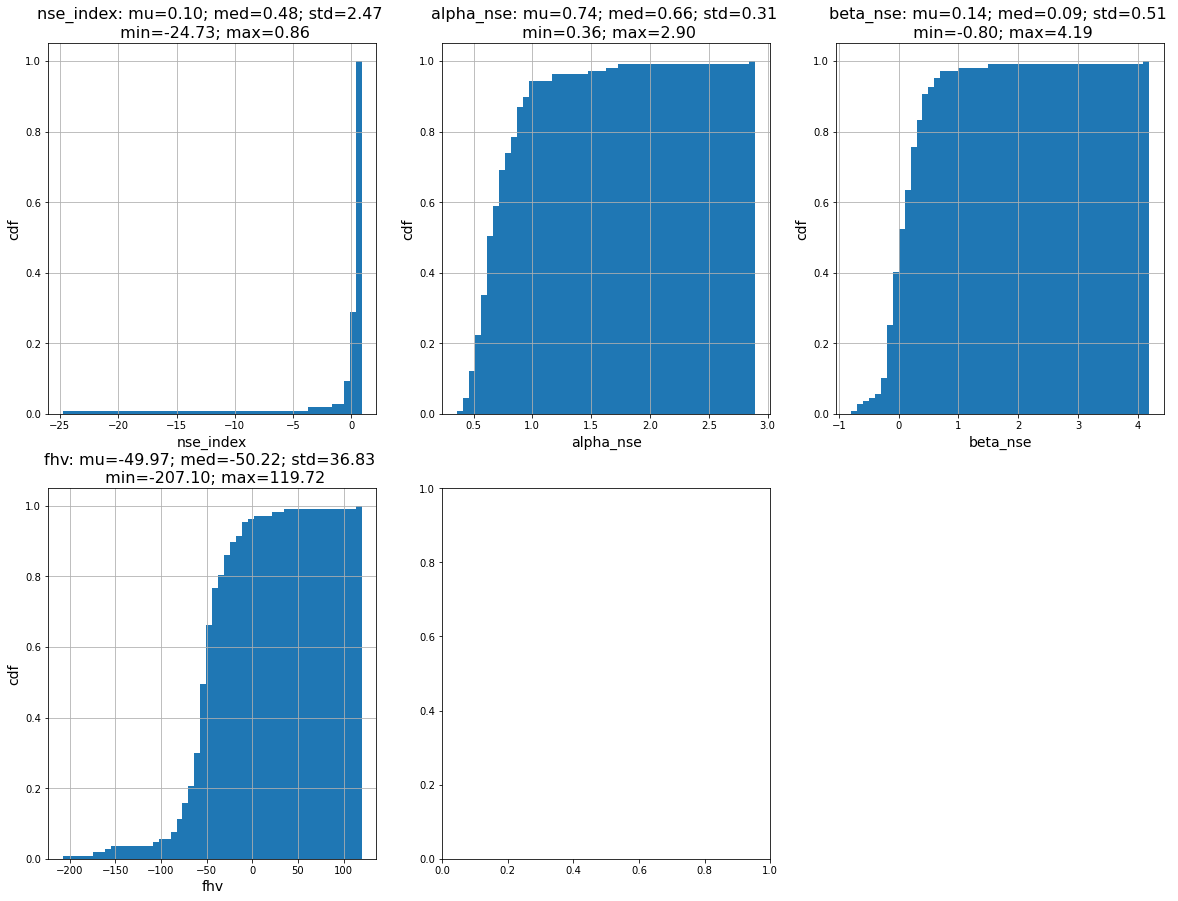

In [98]:
hrus = df_output['HRU'].unique()
nse_array = np.array([])
for hru in hrus:
    df_hru = df_output[df_output['HRU']==hru]
    obs = rev_transform(df_hru['OBS_RUN'].values.astype(np.float))
    mean_obs = np.ones(len(obs))*obs.mean()
    #print(mean_obs)
    mod = rev_transform(df_hru['MOD_RUN_MU'].values.astype(np.float))
    nse_array = np.append(nse_array, NSE.nse(obs,mean_obs,mod))

#print(f"Median NSE = {np.median(nse_array)}")
#print(f"Mean NSE = {nse_array.mean()}")
#print(f"NSE std = {nse_array.std()}")
print(len(nse_array))

list_metrics = ['nse_index','alpha_nse','beta_nse','fhv','flv','fms']

i = 0
fig = plt.figure(figsize=[20,15])
for m in list_metrics:
    i += 1
    plt.subplot(2,3,i)
    plt.hist(df_output_2[m], bins=50, density=True, 
         histtype='stepfilled',
         cumulative=True)
    plt.grid()
    
    plt.ylabel("cdf",fontsize = 14)
    plt.xlabel(m,fontsize=14)
    plt.title("%s: mu=%.2f; med=%.2f; std=%.2f \n min=%.2f; max=%.2f" % (m, df_output_2[m].mean(), df_output_2[m].median(), df_output_2[m].std(), df_output_2[m].min(), df_output_2[m].max()), fontsize=16)
    #plt.show()

4235


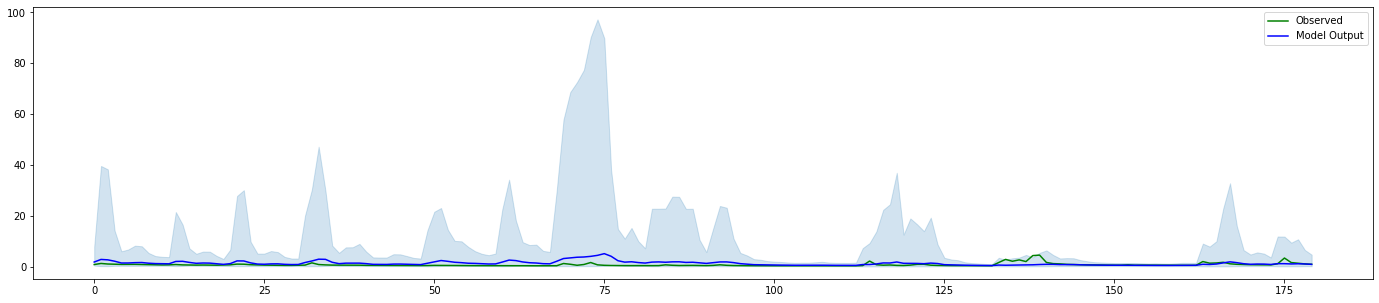

In [63]:
time_slice = 180
x = np.arange(time_slice)
hru_list = df_output['HRU'].unique()
rand = np.random.randint(len(hru_list))
hru_rand = hru_list[rand]

i = np.random.randint(len(df_output['OBS_RUN'][df_output['HRU']==hru_rand])-time_slice)
print(i)

fig = plt.figure(figsize=(24, 5))

obs = df_output['OBS_RUN'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_mu = df_output['MOD_RUN_MU'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_sigma = df_output['MOD_RUN_SIGMA'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
                         
# Plot model predictions.
plt.plot(x,rev_transform(obs), label='Observed', color='green')
plt.plot(x,rev_transform(pred_mu), label='Model Output', color='blue')

show_std = True

if show_std:
    if dist=='gaussian':
        plt.fill_between(x,
                         rev_transform(pred_mu + 2 * pred_sigma),
                         rev_transform(pred_mu - 2 * pred_sigma),
                         color='tab:blue', alpha=0.2)

    elif dist=='gamma':
        p05 = scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale)
        p95 = scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale)
        plt.fill_between(x,
                        rev_transform(p05),
                        rev_transform(p95),
                        color='tab:blue', alpha=0.2)

plt.legend()
plt.show()

## Test with known datanse_array

In [ ]:
import pickle
path = "test_tasks/generate_test_task_0.pkl"
a_file = open(path, "rb")
task = pickle.load(a_file)
a_file.close()

In [ ]:
import importlib
importlib.reload(convcnp.feature_mask)

In [ ]:
#import convcnp.feature_mask as mask
task = mask.task_mask(task, context_mask, target_mask)

In [ ]:
# Compute average task log-likelihood.
batch_size = task['x_context'].shape[0]
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['f'],task['m'],embedding=feature_embedding_flag)
    obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        
    ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 25))
    for i in range(5):
        plt.subplot(5, 1, i + 1)
        plot_model_task(model, task, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- time: %.3f' % (-ravg.avg, elapsed))